<a href="https://colab.research.google.com/github/gregd190/Generative-Adversarial-Networks-in-Keras/blob/master/Part_2_Drawing_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Networks - Drawing Faces

This notebook will builds on Part I by replacing the fully connected discriminator network with a convolutional CNN. The goal remains to learn how to draw faces using training images from the 'CelebA' dataset. ('http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html')



First, get the dataset from the repository:

In [1]:
#Install the kaggle API

!pip install --upgrade kaggle
!kaggle

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 245kB 5.6MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 113, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:

!cd ~/.kaggle/ && wget https://www.dropbox.com/s/re5gugewsacqf0y/kaggle.json

--2018-11-21 12:28:33--  https://www.dropbox.com/s/re5gugewsacqf0y/kaggle.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/re5gugewsacqf0y/kaggle.json [following]
--2018-11-21 12:28:34--  https://www.dropbox.com/s/raw/re5gugewsacqf0y/kaggle.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc3ec10d2fc5270f3c068971e91.dl.dropboxusercontent.com/cd/0/inline/AWDZEb4-3OAU-4_dNKryOS_tTIRLhHodfxfsaJGmKt03hcqX_RwwaaQTIuTDG2QTK84Q6EzNgEiLlbfERUdngBVY-2is0ra7UbFsZ2vmUopNur52m4oyR44h2i0Pcw43qxUSMC3y3wFC5AIXwr_1mVqwxqsfXaWQczr_aFnmyQ3jGqmr_MTyp3aHydXRSIx1dlA/file [following]
--2018-11-21 12:28:34--  https://ucc3ec10d2fc5270f3c068971e91.dl.dropboxusercontent.com/cd/0/inline/AWDZEb4-3OAU-4_dNKryOS_tTIRLhHodfxfsaJGmKt03hcqX_Rwwaa

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.21G/1.21G [00:11<00:00, 123MB/s]
100% 1.21G/1.21G [00:11<00:00, 115MB/s]


In [4]:
!dir

celeba-dataset.zip  sample_data


In [5]:
!unzip celeba-dataset.zip -d /celeba-dataset

Archive:  celeba-dataset.zip
  inflating: /celeba-dataset/list_attr_celeba.csv  
  inflating: /celeba-dataset/img_align_celeba.zip  
  inflating: /celeba-dataset/list_landmarks_align_celeba.csv  
  inflating: /celeba-dataset/list_bbox_celeba.csv  
  inflating: /celeba-dataset/list_eval_partition.csv  


In [6]:
!cd /celeba-dataset/ && rm -r list** && dir

img_align_celeba.zip


Only 20000 images will be extracted, to avoid memory issues on google colab:

In [7]:
!cd /celeba-dataset/ &&  unzip -Z1 img_align_celeba.zip | head -20001 | sed 's| |\\ |g' | xargs unzip img_align_celeba.zip


Archive:  img_align_celeba.zip
   creating: img_align_celeba/
 extracting: img_align_celeba/000001.jpg  
 extracting: img_align_celeba/000002.jpg  
 extracting: img_align_celeba/000003.jpg  
 extracting: img_align_celeba/000004.jpg  
 extracting: img_align_celeba/000005.jpg  
 extracting: img_align_celeba/000006.jpg  
 extracting: img_align_celeba/000007.jpg  
 extracting: img_align_celeba/000008.jpg  
 extracting: img_align_celeba/000009.jpg  
 extracting: img_align_celeba/000010.jpg  
 extracting: img_align_celeba/000011.jpg  
 extracting: img_align_celeba/000012.jpg  
 extracting: img_align_celeba/000013.jpg  
 extracting: img_align_celeba/000014.jpg  
 extracting: img_align_celeba/000015.jpg  
 extracting: img_align_celeba/000016.jpg  
 extracting: img_align_celeba/000017.jpg  
 extracting: img_align_celeba/000018.jpg  
 extracting: img_align_celeba/000019.jpg  
 extracting: img_align_celeba/000020.jpg  
 extracting: img_align_celeba/000021.jpg  
 extracting: img_align_celeba/00002

Great. We have a folder full of face images with nothing else. 

Now import the necessary libraries:

In [8]:
#Import the necessary libraries

import numpy as np
import keras
import struct
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Reshape, LeakyReLU
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from os import walk
from tqdm import tqdm
import cv2


Using TensorFlow backend.


Get a list of all the image files:

In [9]:
image_files = []
for (dirpath, dirnames, filenames) in walk('/celeba-dataset/img_align_celeba'):
    image_files.extend(filenames)
    
print(image_files[0:10])
print(len(image_files))

['011511.jpg', '013651.jpg', '016989.jpg', '016340.jpg', '019789.jpg', '015266.jpg', '017960.jpg', '006184.jpg', '012249.jpg', '004900.jpg']
19999


As planned there are 20,000 image files and we have a list of their filename for simple loading. 

Reduce the images to a fixed size of 28x28 pixels to keep the training
time down. Also normalise the pixel values to between 0 and 1, as the output of the generator NN (sigmoid activation) will be in this range:

In [10]:
#Initialize an array to hold the pixel data
train_images = []

# dimensions of our images.
img_width, img_height = 28, 28

#load images into arrays - Note loading all ~10000 images at once caused an out of memory error, so either the first or last 5000 images are loaded at a time.
 
for fname in tqdm(image_files):
    img = cv2.imread('/celeba-dataset/img_align_celeba/{}'.format(fname))
    img = cv2.resize(img, (img_width, img_height))
    img = img/255.
    train_images.append(img)
    


100%|██████████| 19999/19999 [00:14<00:00, 1338.23it/s]


Check that the data arrays look correct, and inspect an image at random:

Shape of train_images =  (19999, 28, 28, 3)
max 1.0
min 0.0


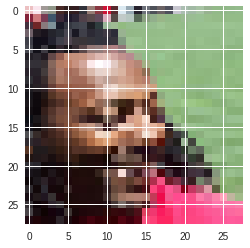

In [11]:

print('Shape of train_images = ',np.shape(train_images))

test_image = train_images[np.random.randint(0,len(train_images))]

im2 = test_image.copy()
im2[:, :, 0] = test_image[:, :, 2]
im2[:, :, 2] = test_image[:, :, 0]
plt.imshow(im2)

print('max',np.max(im2))
print('min',np.min(im2))



Build the networks:

In [12]:
def build_discriminator_model(input_shape, num_output_nodes, lr, num_conv_layers):
    
    model = Sequential()
    
    model.add(Conv2D(128, (5,5), padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    for i in range(num_conv_layers-1):
        model.add(Conv2D(128, (5,5), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(num_output_nodes, activation = 'sigmoid')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

def build_generator_model(input_shape, lr, num_conv_layers):
    
    model = Sequential()
    
    model.add(Dense(img_height*img_width*3, input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((img_width,img_height,3), input_shape=(img_height*img_width*3,)))
    
    for i in range(num_conv_layers):
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
    
    #model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
    
    model.add(Conv2D(3, (3,3), padding='same', activation='sigmoid'))
        
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

#Discriminator takes input of 784 pixels  
discriminator = build_discriminator_model((img_height,img_width,3), 1, 3e-5, 2)

#Generator will take 100 inputs of random noise
generator = build_generator_model((100,), 1e-4, 3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       9728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
__________

In [0]:
def build_gan_model(discriminator, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(100,))
    # the output of the generator (an image)
    generated_image = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
    gan.compile(loss='binary_crossentropy', optimizer=adam)
    return gan

gan_model = build_gan_model(discriminator, generator) 

We need a way of determining whether to feed an image from the training set, or an image from the generator to the discriminator. We'll create a function that decides based on a 50:50 split

In [0]:
#Will return either a randomly generated image, or an image from the training set, plus either a 0 or 1, indicating whether the image is real(1) or generated(0)

def pick_image():
  if np.random.uniform() < 0.5:
    a = np.random.randint(0,len(train_images))
    #print('TRUE IMAGE', 'max =', np.max(train_images[a]), 'min=', np.min(train_images[a]))
    return(np.reshape(train_images[a],(img_height,img_width,3)),np.random.uniform(0.999,1))
  else:
    random_inputs = np.array([np.random.uniform(0,1,100)])
    generated_image = generator.predict(random_inputs)      
    generated_image = np.reshape(generated_image,(img_height,img_width,3))
    #generated_image = convert_to_255(generated_image)
    #print('GENERATED IMAGE', 'max =', np.max(generated_image), 'min=', np.min(generated_image))
    
    return(generated_image,np.random.uniform(0,0.001))

  

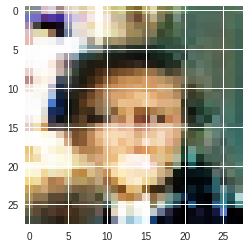

max 0.9992005
min 0.002043809


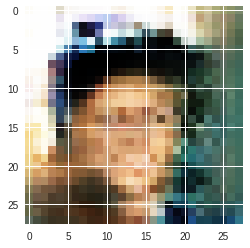

max 0.99997604
min 0.0001168888


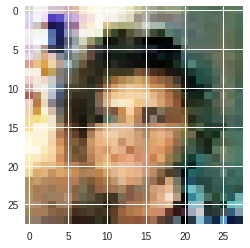

max 0.99693906
min 0.003977044


In [23]:
def plot_generated_images(num):
  
  for i in range(num):
    noise = np.array([np.random.uniform(0,1,100)])
    generated_image = generator.predict(noise)
    generated_image = generated_image.reshape(img_height, img_width, 3)
    #generated_image = convert_to_255(generated_image)
    
    im2 = generated_image.copy()
    im2[:, :, 0] = generated_image[:, :, 2]
    im2[:, :, 2] = generated_image[:, :, 0]
    plt.imshow(im2)
    plt.show()

    print('max',np.max(im2))
    print('min',np.min(im2))

  return
  
#Test it - At this stage it should just be random pixels
plot_generated_images(3)


In [0]:
def plot_progress():
    #Discriminator loss is extremely spiky. We'll average it over a few batches to better see trends. 
  discriminator_loss_rolling_avg =[]
  discriminator_loss_iter_counter = []
  for i in range(3,len(discriminator_loss_history)):
    discriminator_loss_rolling_avg.append(np.average(discriminator_loss_history[i-3:i]))
    discriminator_loss_iter_counter.append(i)

  plt.subplot('211')
  plt.plot(gan_loss_history,'r', label='GAN Loss')
  plt.xlim(0, len(discriminator_loss_iter_counter))
  plt.legend()
  
  plt.subplot('212')
  plt.semilogy(discriminator_loss_iter_counter,discriminator_loss_rolling_avg,'c', label='Disc. Loss')
  plt.legend()
  plt.show()

  print(gan_loss_history[-1])
  print(discriminator_loss_rolling_avg[-1])

Now we need to feed our image into our discriminator model, and then train the two models based on the accuracy of the prediction:

In [0]:
def train(batches=1, batch_size=256):
    
    for e in range(1, batches+1):
           
        #Initialize arrays for storage of images and labels for the entire batch
        images_array = []
        labels_array = []
        
        #Get images and labels
        for b in range(batch_size):
        
          image, label = pick_image()
          images_array.append(image)
          labels_array.append([label])
        
        
        images_array = np.array(images_array)
        labels_array = np.array(labels_array)
        
        # Train discriminator
        discriminator.trainable = True
        
        history = discriminator.fit(images_array, labels_array, verbose=False)
        discriminator_loss_history.append(history.history["loss"])
        
        # Train generator
        noise_array = np.random.uniform(0,1,size=[batch_size,100])
        ones_array = np.ones((batch_size,1))
        
        discriminator.trainable = False
        
        history = gan_model.fit(noise_array, ones_array, verbose=False)
        gan_loss_history.append(history.history["loss"])
        
        #Print images every 100 batches
        if e%100==0:
          print('After ', e,' batches:')
          plot_generated_images(2)
          plot_progress()
          
        
        
    return

# Initialise arrays to store the loss information during training.         
discriminator_loss_history = []
gan_loss_history = []




In [0]:
def pretrain_discriminator(batches=500, batch_size=1028):
   for e in range(1, batches+1):
           
        #Initialize arrays for storage of images and labels for the entire batch
        images_array = []
        labels_array = []
        
        #Get images and labels
        for b in range(batch_size):
        
          image, label = pick_image()
          images_array.append(image)
          labels_array.append([label])
        
        images_array = np.array(images_array)
        labels_array = np.array(labels_array)
        
        # Train discriminator
        discriminator.trainable = True
        
        history = discriminator.fit(images_array, labels_array, verbose=False)
        discriminator_loss_history.append(history.history["loss"])
        
        
        #Print images every 100 batches
        if e>3 and e%4==0:
          print('After ', e,' batches:')
          discriminator_loss_rolling_avg =[]
          discriminator_loss_iter_counter = []
          for i in range(3,len(discriminator_loss_history)):
            discriminator_loss_rolling_avg.append(np.average(discriminator_loss_history[i-3:i]))
            discriminator_loss_iter_counter.append(i)
          plt.semilogy(discriminator_loss_iter_counter,discriminator_loss_rolling_avg,'c', label='Disc. Loss')
          plt.legend()
          plt.show()
   
     

pretrain_discriminator(batches=2, batch_size=1)

Train for 2000 batches to see how it performs.

After  100  batches:
MINMAX 0.00035930067 0.97477007


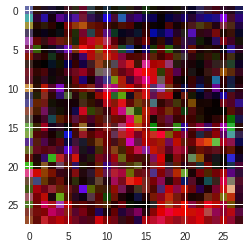

max 0.97477007
min 0.00035930067
MINMAX 0.00022471012 0.9563306


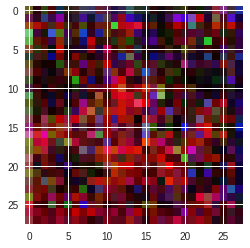

max 0.9563306
min 0.00022471012


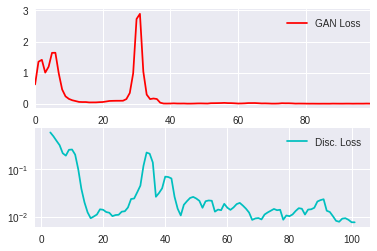

[0.0054674896819051355]
0.007622646769353499
After  200  batches:
MINMAX 0.0010315483 0.94346374


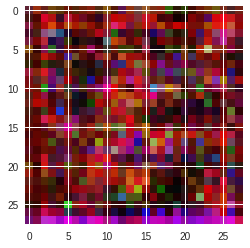

max 0.94346374
min 0.0010315483
MINMAX 0.0007441073 0.9462246


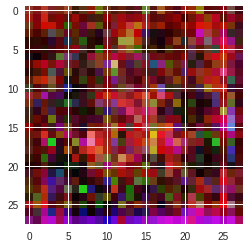

max 0.9462246
min 0.0007441073


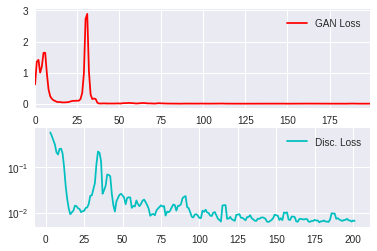

[0.00287652516271919]
0.006574843544512987
After  300  batches:
MINMAX 2.3581057e-07 0.9999993


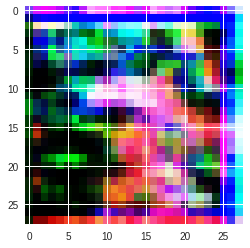

max 0.9999993
min 2.3581057e-07
MINMAX 2.4853935e-11 0.99999964


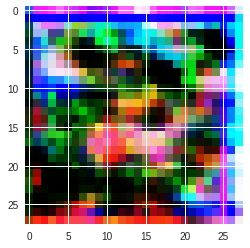

max 0.99999964
min 2.4853935e-11


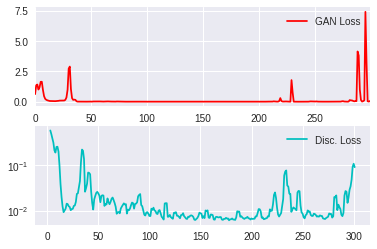

[0.053619928599800915]
0.09056750209614013
After  400  batches:
MINMAX 6.1514093e-06 1.0


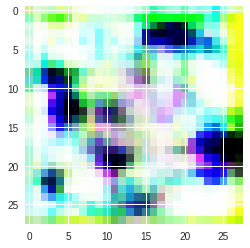

max 1.0
min 6.1514093e-06
MINMAX 7.016574e-07 0.9999995


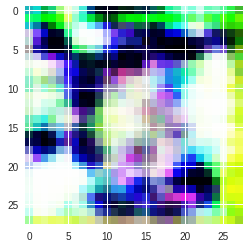

max 0.9999995
min 7.016574e-07


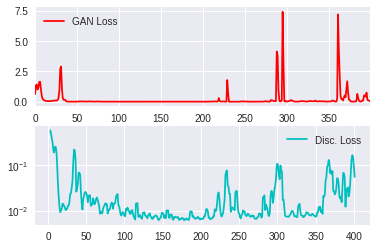

[0.0639150538481772]
0.05514703855927413
After  500  batches:
MINMAX 0.000107269334 0.99998474


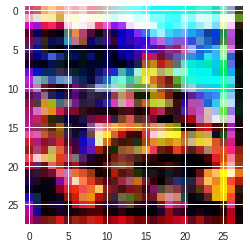

max 0.99998474
min 0.000107269334
MINMAX 0.00010675484 0.999956


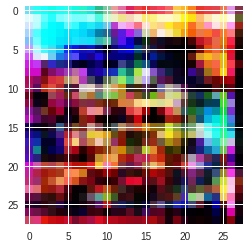

max 0.999956
min 0.00010675484


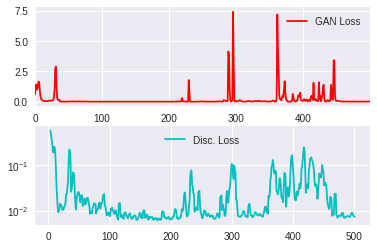

[0.012550055631436408]
0.00736747410458823
After  600  batches:
MINMAX 0.0053023174 0.999995


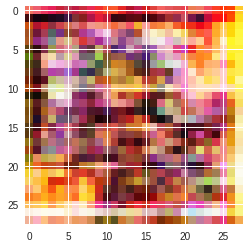

max 0.999995
min 0.0053023174
MINMAX 0.014447486 0.99965453


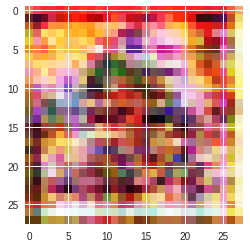

max 0.99965453
min 0.014447486


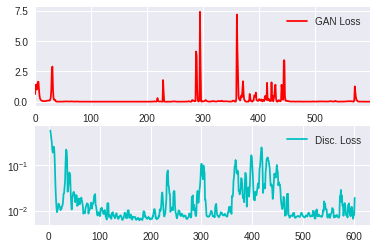

[0.003417981250095181]
0.019140758842695504
After  700  batches:
MINMAX 0.025836095 0.99897146


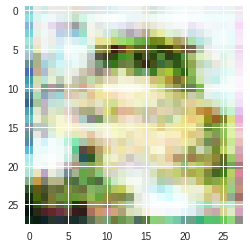

max 0.99897146
min 0.025836095
MINMAX 0.039776243 0.999728


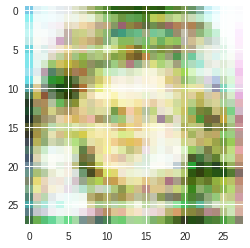

max 0.999728
min 0.039776243


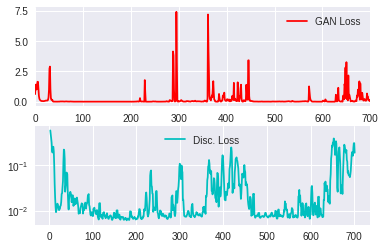

[0.03765752795152366]
0.18795093921168396
After  800  batches:
MINMAX 3.0345007e-05 0.99997544


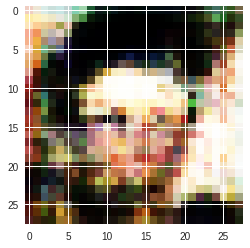

max 0.99997544
min 3.0345007e-05
MINMAX 6.1126484e-05 0.9999857


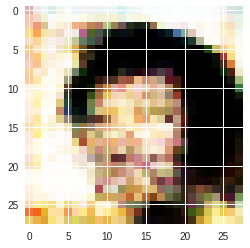

max 0.9999857
min 6.1126484e-05


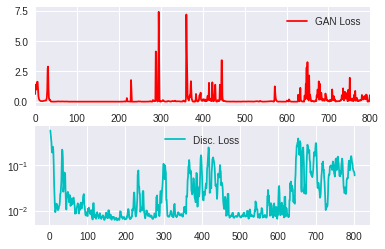

[0.5346106514334679]
0.05944258186112469
After  900  batches:
MINMAX 7.461028e-05 0.98679745


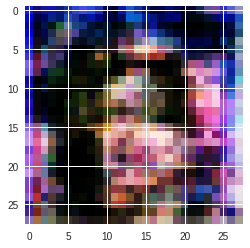

max 0.98679745
min 7.461028e-05
MINMAX 7.552928e-06 0.99726653


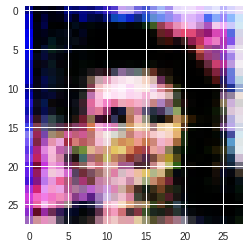

max 0.99726653
min 7.552928e-06


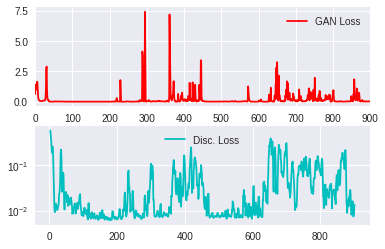

[0.029064270202070475]
0.01334887775980557
After  1000  batches:
MINMAX 0.0031664276 0.99641126


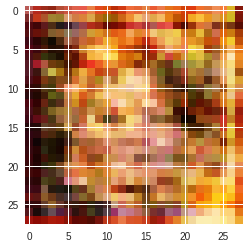

max 0.99641126
min 0.0031664276
MINMAX 0.0020549188 0.9960828


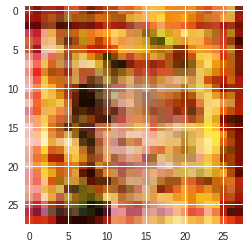

max 0.9960828
min 0.0020549188


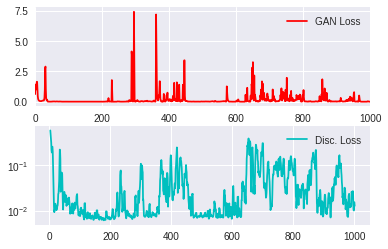

[0.002945263491710648]
0.012787849642336369
After  1100  batches:
MINMAX 0.00072161603 0.9797507


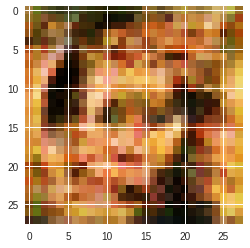

max 0.9797507
min 0.00072161603
MINMAX 0.0022556817 0.99492985


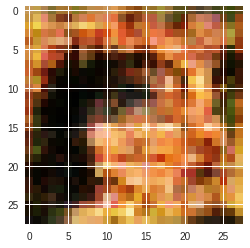

max 0.99492985
min 0.0022556817


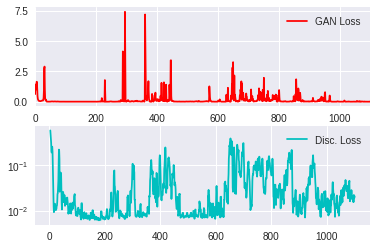

[0.005462385655846447]
0.020695429178886116
After  1200  batches:
MINMAX 2.7706776e-05 0.9987136


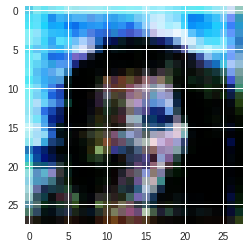

max 0.9987136
min 2.7706776e-05
MINMAX 0.00052410655 0.9866368


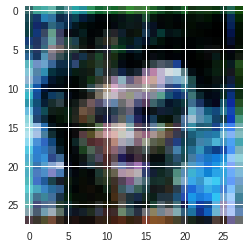

max 0.9866368
min 0.00052410655


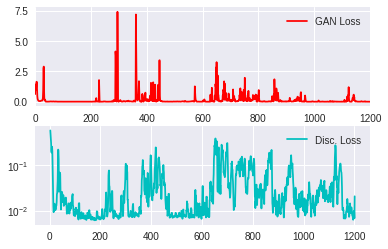

[0.000676271905831527]
0.020690054264074813
After  1300  batches:
MINMAX 0.0018995989 0.99655557


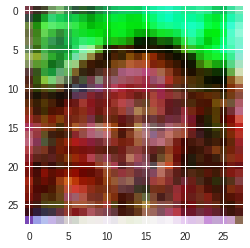

max 0.99655557
min 0.0018995989
MINMAX 0.0019005466 0.9732843


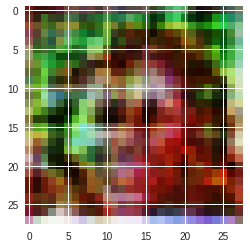

max 0.9732843
min 0.0019005466


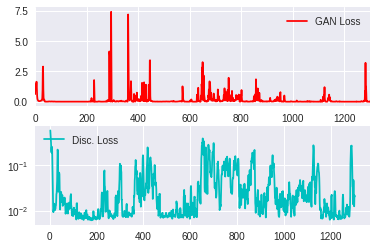

[0.01565579295856878]
0.020487672940362245
After  1400  batches:
MINMAX 2.2390957e-05 0.99348927


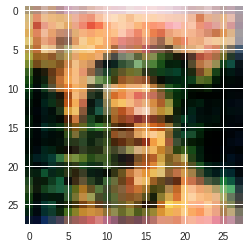

max 0.99348927
min 2.2390957e-05
MINMAX 0.00055328524 0.9983718


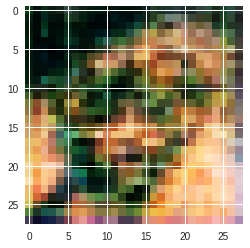

max 0.9983718
min 0.00055328524


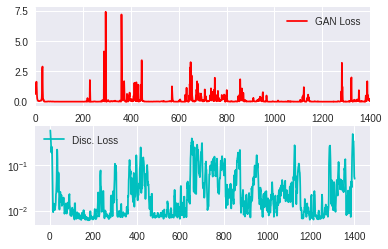

[0.03877709340304136]
0.050337272114120424
After  1500  batches:
MINMAX 0.0132731 0.9952667


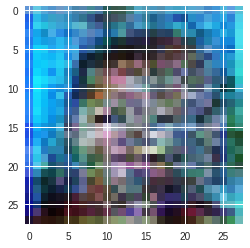

max 0.9952667
min 0.0132731
MINMAX 0.010101705 0.9814834


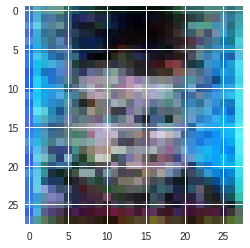

max 0.9814834
min 0.010101705


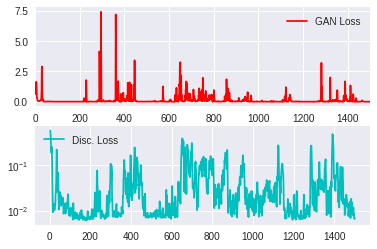

[0.0008460411918349564]
0.006769573820444445
After  1600  batches:
MINMAX 0.003069393 0.999858


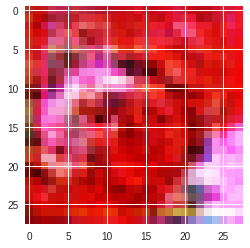

max 0.999858
min 0.003069393
MINMAX 0.0043497793 0.9986002


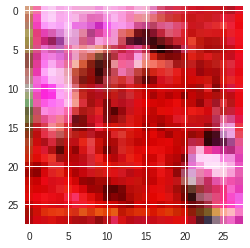

max 0.9986002
min 0.0043497793


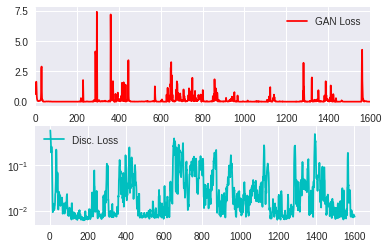

[0.0019015454963664524]
0.007447587753025194
After  1700  batches:
MINMAX 0.0010341702 0.9992199


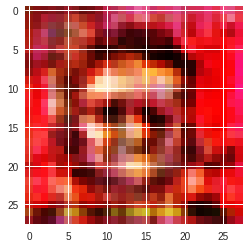

max 0.9992199
min 0.0010341702
MINMAX 0.00031800862 0.9999044


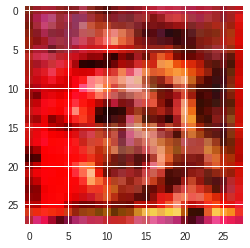

max 0.9999044
min 0.00031800862


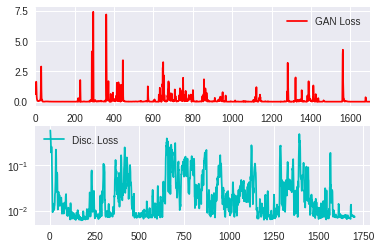

[0.00034495285581215285]
0.007351800100877881
After  1800  batches:
MINMAX 0.0013252016 0.9983772


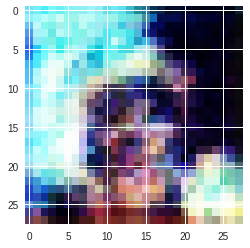

max 0.9983772
min 0.0013252016
MINMAX 0.004010099 0.9886855


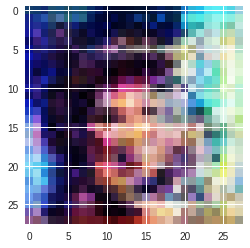

max 0.9886855
min 0.004010099


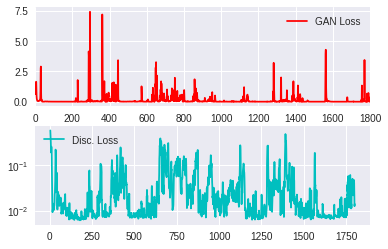

[0.34453169256448746]
0.013994266434262196
After  1900  batches:
MINMAX 0.0034713158 0.9981674


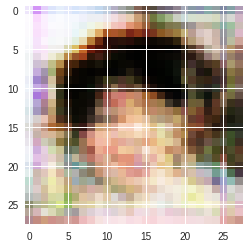

max 0.9981674
min 0.0034713158
MINMAX 0.010040262 0.9758295


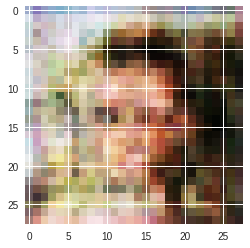

max 0.9758295
min 0.010040262


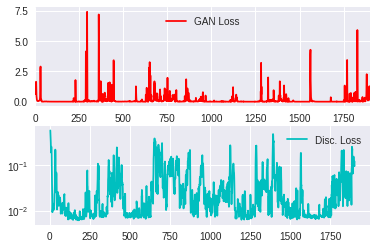

[0.3703194912523031]
0.09681416108893852
After  2000  batches:
MINMAX 0.009592296 0.9994655


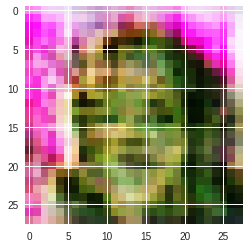

max 0.9994655
min 0.009592296
MINMAX 0.006484791 0.99975604


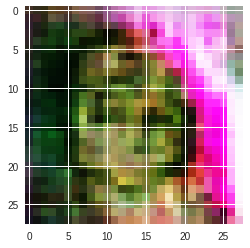

max 0.99975604
min 0.006484791


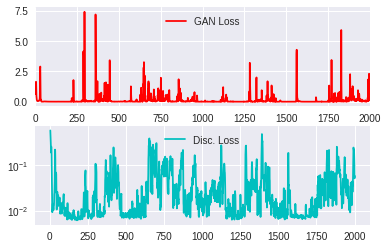

[0.2459131982177496]
0.05816402278530101
After  2100  batches:
MINMAX 4.9918947e-07 0.5719051


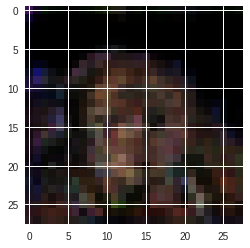

max 0.5719051
min 4.9918947e-07
MINMAX 2.520724e-05 0.66692233


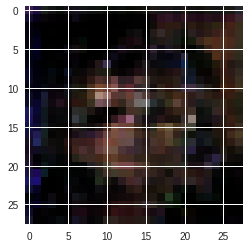

max 0.66692233
min 2.520724e-05


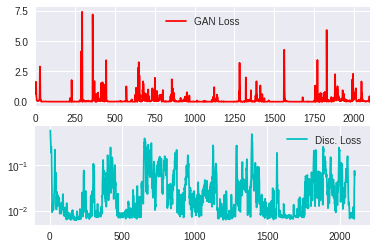

[8.729603746360226e-05]
0.05970110179623589
After  2200  batches:
MINMAX 7.114148e-05 0.7329104


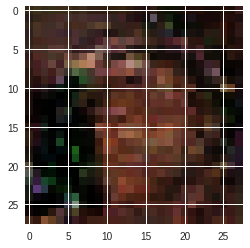

max 0.7329104
min 7.114148e-05
MINMAX 2.7925858e-05 0.73857087


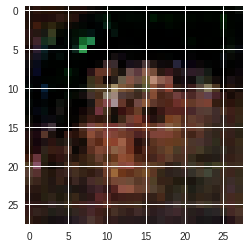

max 0.73857087
min 2.7925858e-05


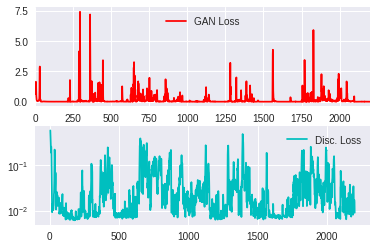

[0.0008082416097749956]
0.009006621277270218
After  2300  batches:
MINMAX 1.5644877e-05 0.72737634


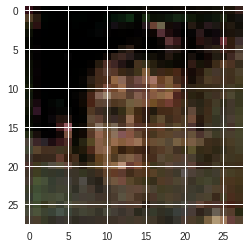

max 0.72737634
min 1.5644877e-05
MINMAX 0.001120775 0.8872164


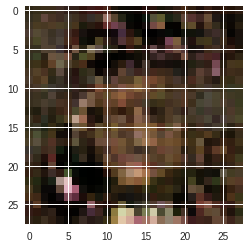

max 0.8872164
min 0.001120775


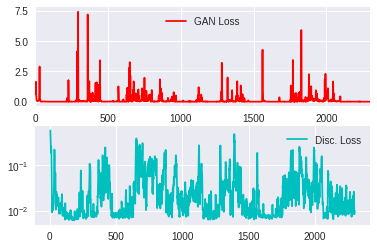

[0.0001635871658436372]
0.009987211281744143
After  2400  batches:
MINMAX 0.00036140322 0.7988721


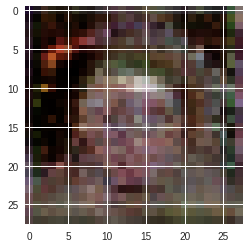

max 0.7988721
min 0.00036140322
MINMAX 0.0013087116 0.72235036


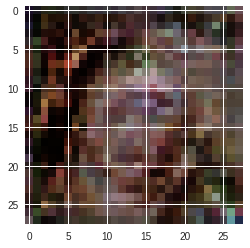

max 0.72235036
min 0.0013087116


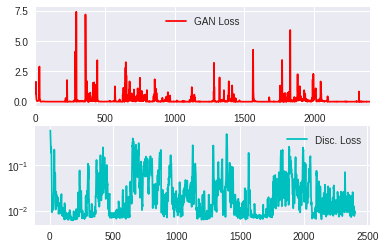

[0.0005991435500618536]
0.00875995121896267
After  2500  batches:
MINMAX 0.0012078816 0.984201


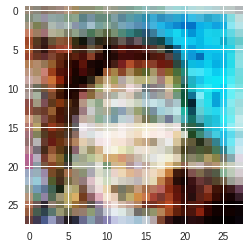

max 0.984201
min 0.0012078816
MINMAX 0.00016901885 0.97791094


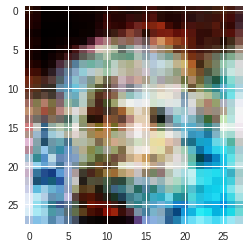

max 0.97791094
min 0.00016901885


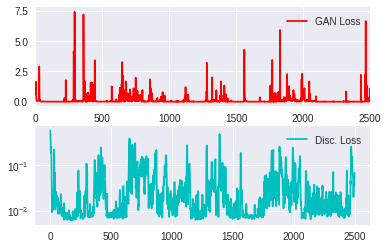

[0.558921430259943]
0.06828949848810832
After  2600  batches:
MINMAX 0.0021465907 0.9907665


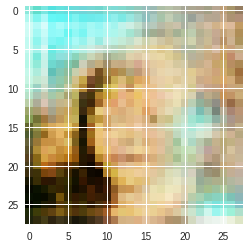

max 0.9907665
min 0.0021465907
MINMAX 1.2018745e-05 0.986246


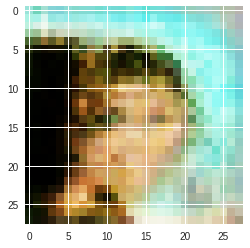

max 0.986246
min 1.2018745e-05


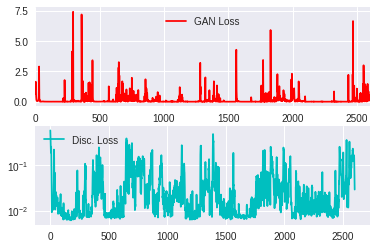

[0.1369333304464817]
0.029176642982444417
After  2700  batches:
MINMAX 0.000796048 0.9398136


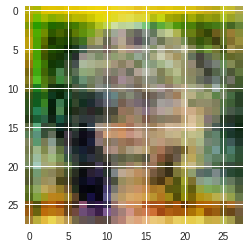

max 0.9398136
min 0.000796048
MINMAX 0.0016044475 0.9087338


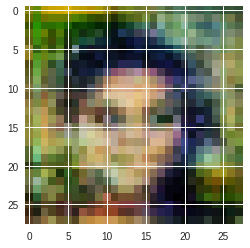

max 0.9087338
min 0.0016044475


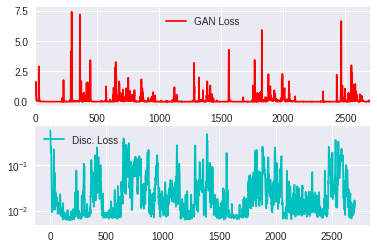

[0.005257189623080194]
0.011483357734202096
After  2800  batches:
MINMAX 0.03486916 0.98500514


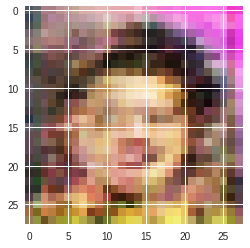

max 0.98500514
min 0.03486916
MINMAX 0.01014592 0.9995141


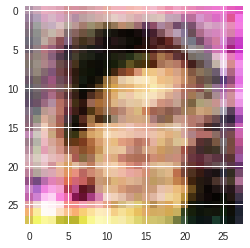

max 0.9995141
min 0.01014592


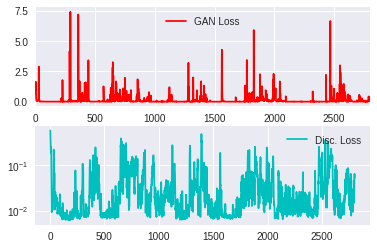

[0.054148110444657505]
0.05280074795397619
After  2900  batches:
MINMAX 0.00024094708 0.9669125


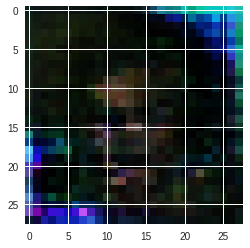

max 0.9669125
min 0.00024094708
MINMAX 0.00021892169 0.9654574


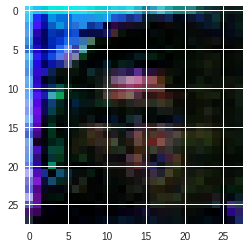

max 0.9654574
min 0.00021892169


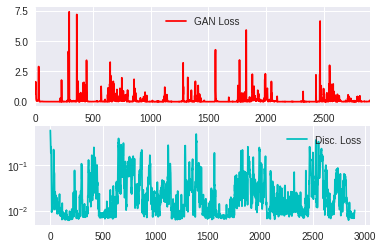

[0.043690315214917064]
0.010196387127507478
After  3000  batches:
MINMAX 1.9376856e-13 0.8170709


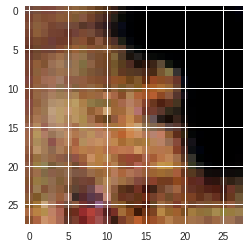

max 0.8170709
min 1.9376856e-13
MINMAX 1.3373726e-05 0.8725258


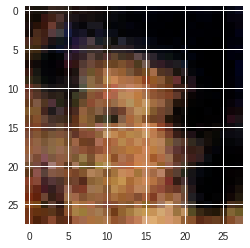

max 0.8725258
min 1.3373726e-05


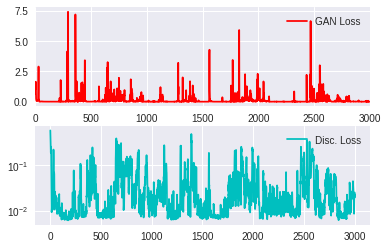

[0.0007687302058911882]
0.025146969923904788
After  3100  batches:
MINMAX 3.5197292e-05 1.0


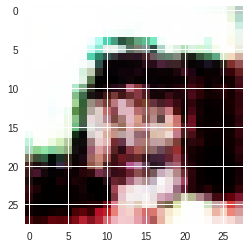

max 1.0
min 3.5197292e-05
MINMAX 8.296261e-05 0.99997866


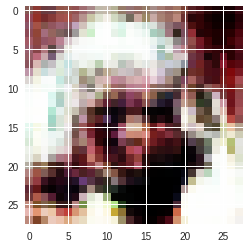

max 0.99997866
min 8.296261e-05


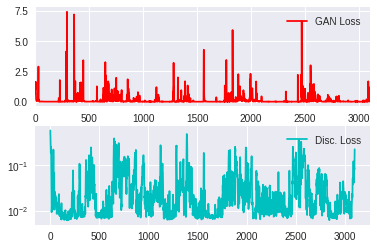

[0.05328550119884312]
0.22342950423868993
After  3200  batches:
MINMAX 0.019192476 0.98775804


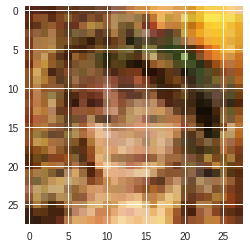

max 0.98775804
min 0.019192476
MINMAX 0.0067021134 0.9880413


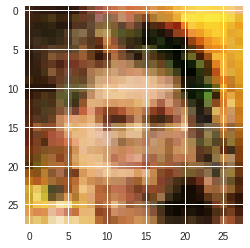

max 0.9880413
min 0.0067021134


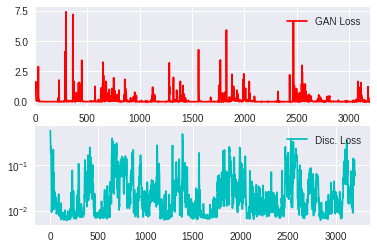

[0.023265423951670527]
0.07154028344666585
After  3300  batches:
MINMAX 0.032590378 0.9673625


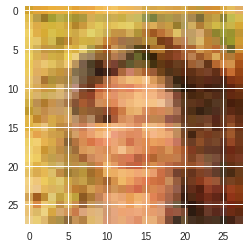

max 0.9673625
min 0.032590378
MINMAX 0.035191298 0.95017695


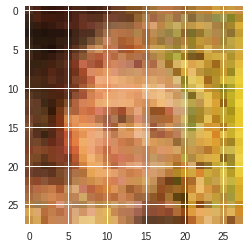

max 0.95017695
min 0.035191298


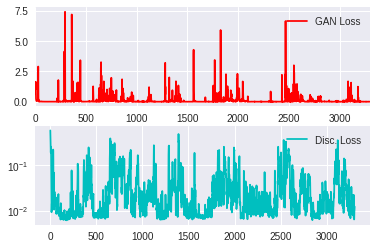

[0.0007426928314089309]
0.012273220694623888
After  3400  batches:
MINMAX 8.777245e-06 0.9913248


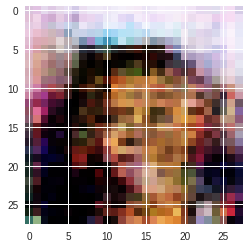

max 0.9913248
min 8.777245e-06
MINMAX 0.00023282575 0.9681277


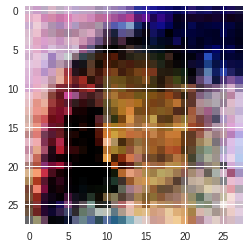

max 0.9681277
min 0.00023282575


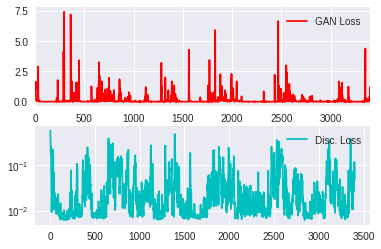

[1.1921754032373428]
0.049714367875518896
After  3500  batches:
MINMAX 0.00019375556 0.92222637


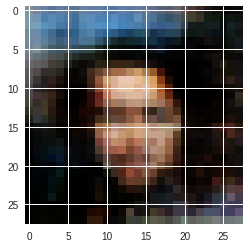

max 0.92222637
min 0.00019375556
MINMAX 0.0001855655 0.8443725


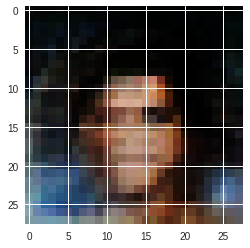

max 0.8443725
min 0.0001855655


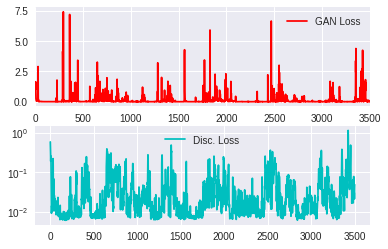

[0.06399964704178274]
0.048608421658476196
After  3600  batches:
MINMAX 0.0013870945 0.8931334


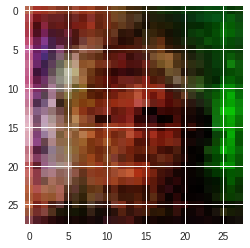

max 0.8931334
min 0.0013870945
MINMAX 0.00032535207 0.88031614


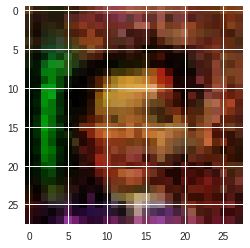

max 0.88031614
min 0.00032535207


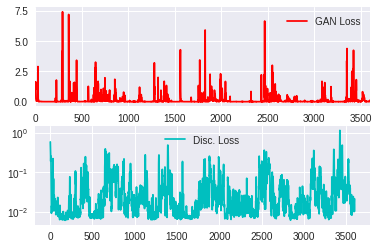

[0.11810435494408011]
0.02113189231992389
After  3700  batches:
MINMAX 9.125287e-06 0.9978795


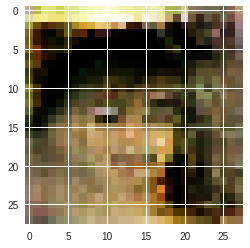

max 0.9978795
min 9.125287e-06
MINMAX 5.3950243e-05 0.95336497


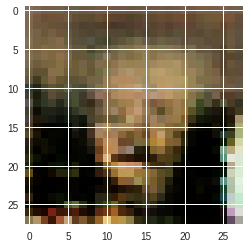

max 0.95336497
min 5.3950243e-05


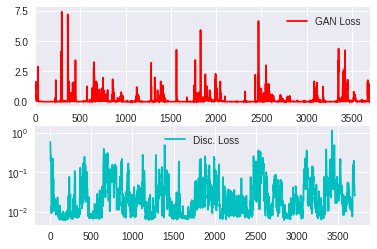

[0.007234209711896256]
0.026751012075692415
After  3800  batches:
MINMAX 0.0002123667 0.8998251


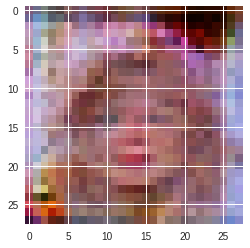

max 0.8998251
min 0.0002123667
MINMAX 5.5127607e-06 0.9550678


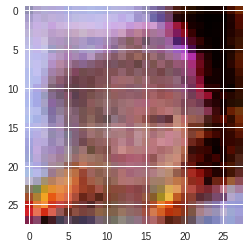

max 0.9550678
min 5.5127607e-06


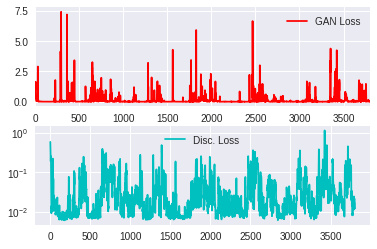

[0.016099522006697953]
0.02113865048158914
After  3900  batches:
MINMAX 2.0635991e-06 0.9899872


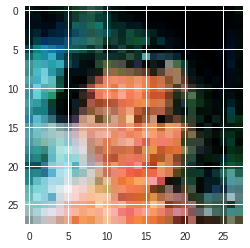

max 0.9899872
min 2.0635991e-06
MINMAX 5.8938326e-08 0.9963097


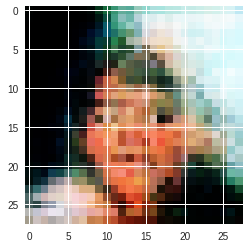

max 0.9963097
min 5.8938326e-08


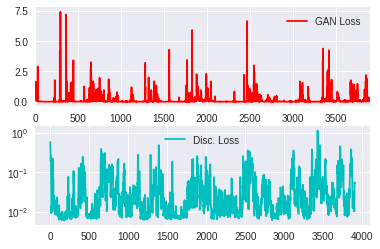

[0.3103116862475872]
0.052265262425256274
After  4000  batches:
MINMAX 0.00020128419 0.9552797


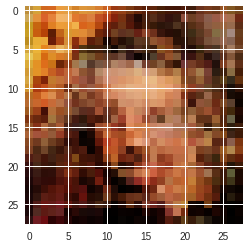

max 0.9552797
min 0.00020128419
MINMAX 5.2011383e-06 0.95041835


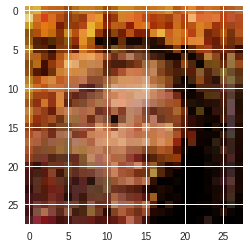

max 0.95041835
min 5.2011383e-06


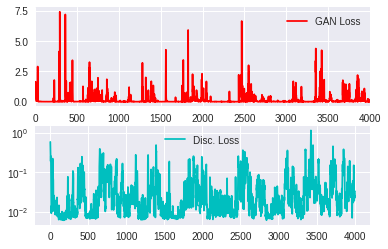

[0.0012230108768562786]
0.03332052441934744
After  4100  batches:
MINMAX 0.0020579288 0.9719883


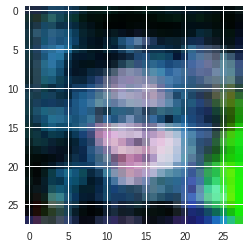

max 0.9719883
min 0.0020579288
MINMAX 8.040547e-08 0.99954283


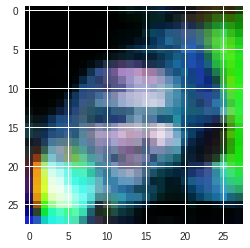

max 0.99954283
min 8.040547e-08


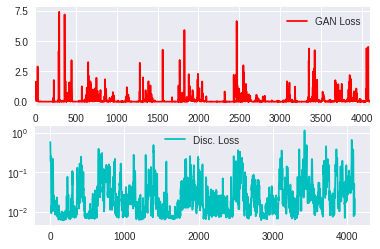

[0.10363419260829687]
0.02124837147615229
After  4200  batches:
MINMAX 0.0033157836 0.9960387


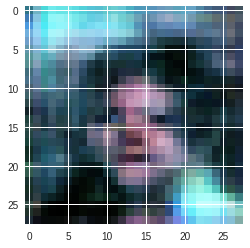

max 0.9960387
min 0.0033157836
MINMAX 3.4479424e-07 0.999984


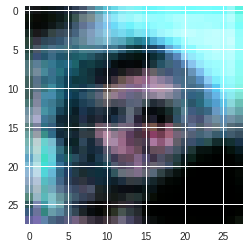

max 0.999984
min 3.4479424e-07


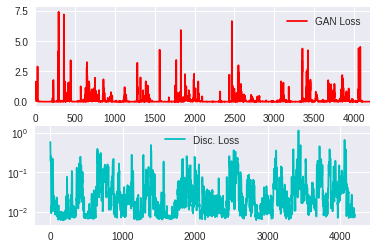

[0.002302528970176354]
0.008213976301097622
After  4300  batches:
MINMAX 2.6872888e-08 0.99496895


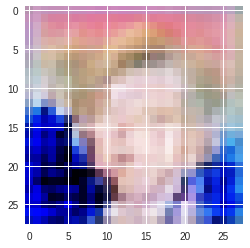

max 0.99496895
min 2.6872888e-08
MINMAX 0.0037142567 0.97618014


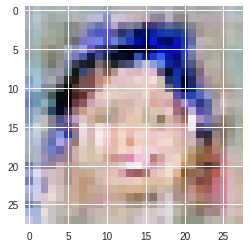

max 0.97618014
min 0.0037142567


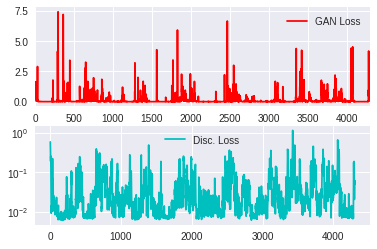

[0.18435179628431797]
0.05002875356391693
After  4400  batches:
MINMAX 0.0015722818 0.99017406


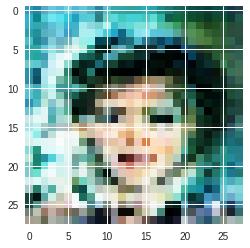

max 0.99017406
min 0.0015722818
MINMAX 0.00047817192 0.9995814


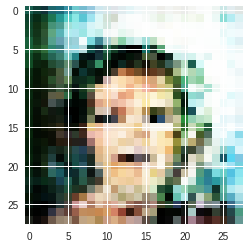

max 0.9995814
min 0.00047817192


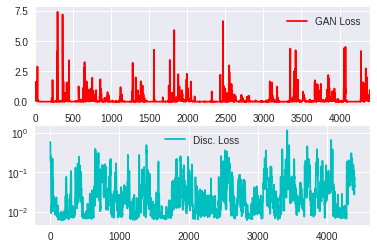

[0.17690332513302565]
0.06796377029968426
After  4500  batches:
MINMAX 0.03255119 0.9999999


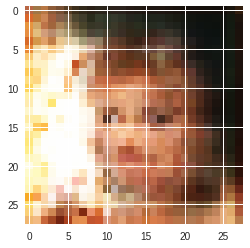

max 0.9999999
min 0.03255119
MINMAX 0.028090425 0.99999547


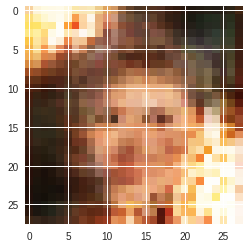

max 0.99999547
min 0.028090425


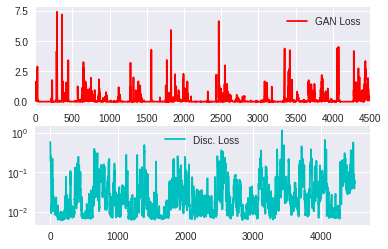

[0.18263348750770092]
0.05667802965035662
After  4600  batches:
MINMAX 0.004344956 0.9998952


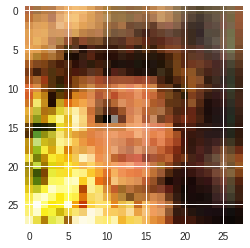

max 0.9998952
min 0.004344956
MINMAX 0.0040081264 0.99998295


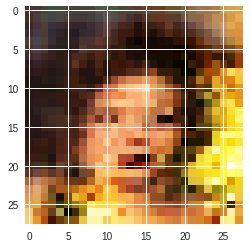

max 0.99998295
min 0.0040081264


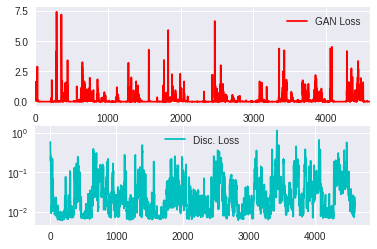

[0.005050625841249712]
0.00980020760713766
After  4700  batches:
MINMAX 0.0056650606 0.9999176


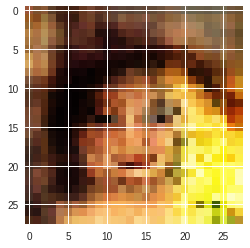

max 0.9999176
min 0.0056650606
MINMAX 0.020896632 0.9889016


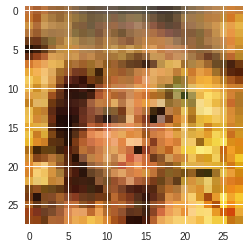

max 0.9889016
min 0.020896632


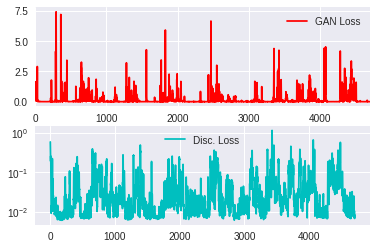

[0.0013235902733867988]
0.008423393960886946
After  4800  batches:
MINMAX 0.004267213 0.99998903


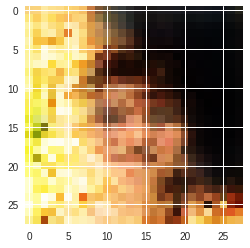

max 0.99998903
min 0.004267213
MINMAX 0.002588676 0.9999076


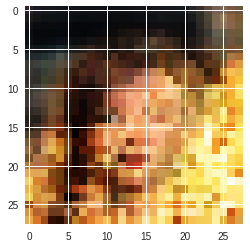

max 0.9999076
min 0.002588676


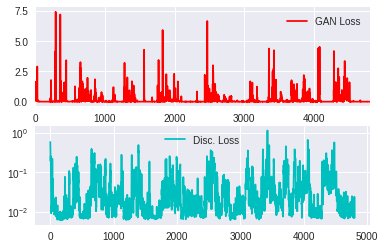

[0.004220588190946728]
0.007203785314535101
After  4900  batches:
MINMAX 3.1303603e-05 1.0


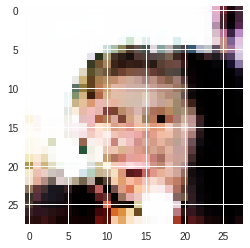

max 1.0
min 3.1303603e-05
MINMAX 5.7065292e-05 1.0


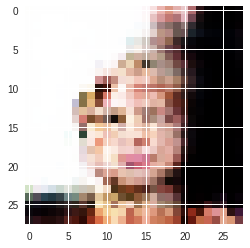

max 1.0
min 5.7065292e-05


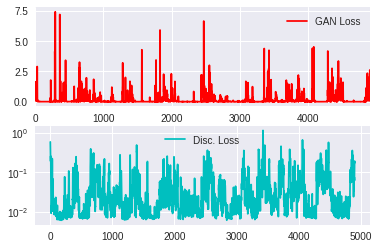

[1.0254056490957737]
0.17208132710463056
After  5000  batches:
MINMAX 0.023447776 0.99991536


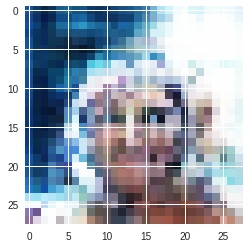

max 0.99991536
min 0.023447776
MINMAX 0.018027894 1.0


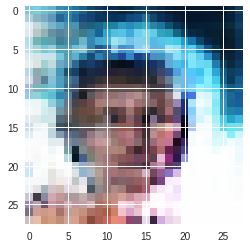

max 1.0
min 0.018027894


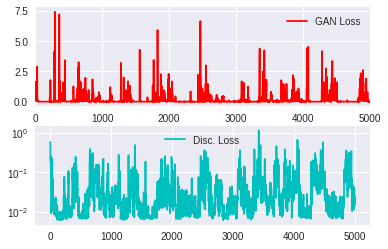

[0.010292593738995492]
0.024442004001078505
After  5100  batches:
MINMAX 1.8040755e-05 1.0


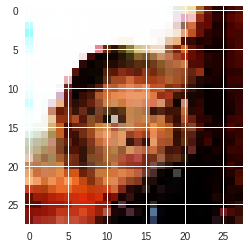

max 1.0
min 1.8040755e-05
MINMAX 4.1181283e-05 1.0


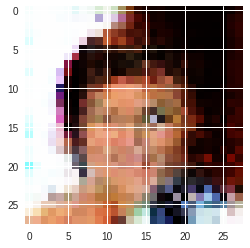

max 1.0
min 4.1181283e-05


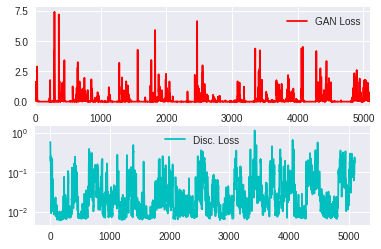

[0.04321898426860571]
0.17144133701610068
After  5200  batches:
MINMAX 6.7580004e-07 0.99931645


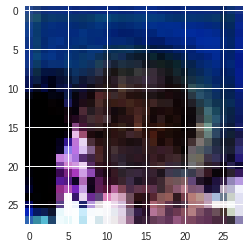

max 0.99931645
min 6.7580004e-07
MINMAX 0.00032792395 0.9690615


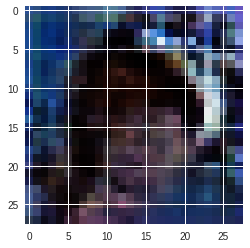

max 0.9690615
min 0.00032792395


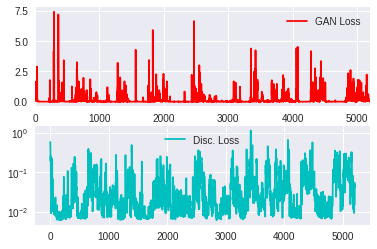

[0.0221777776023373]
0.015344811894465238
After  5300  batches:
MINMAX 4.3163925e-14 0.88000435


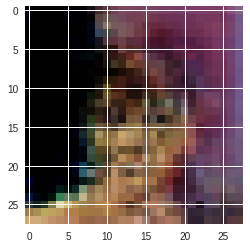

max 0.88000435
min 4.3163925e-14
MINMAX 1.9664862e-08 0.8724759


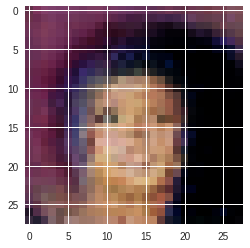

max 0.8724759
min 1.9664862e-08


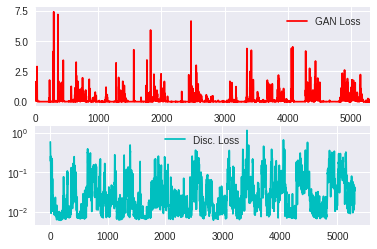

[0.01611890085041523]
0.03361454598295192
After  5400  batches:
MINMAX 6.600977e-05 0.7689197


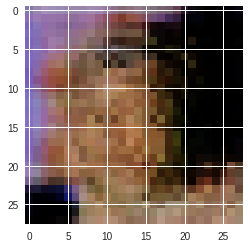

max 0.7689197
min 6.600977e-05
MINMAX 0.00011035527 0.77654815


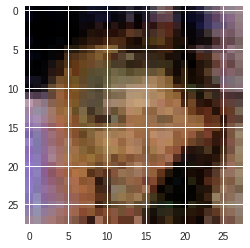

max 0.77654815
min 0.00011035527


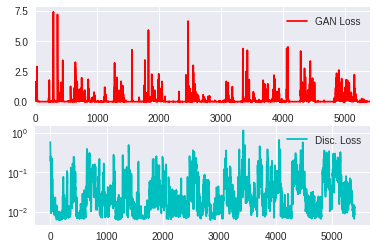

[0.00535155508259777]
0.008647460800906023
After  5500  batches:
MINMAX 1.01243074e-07 0.9588713


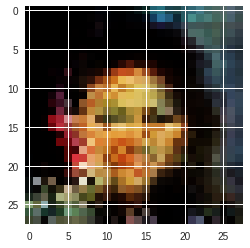

max 0.9588713
min 1.01243074e-07
MINMAX 5.3722066e-10 0.97989655


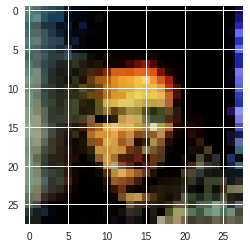

max 0.97989655
min 5.3722066e-10


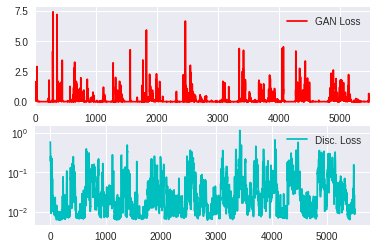

[0.00913959211902693]
0.01184758476059263
After  5600  batches:
MINMAX 1.114721e-08 0.85449296


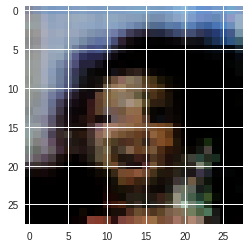

max 0.85449296
min 1.114721e-08
MINMAX 1.6785897e-06 0.8886409


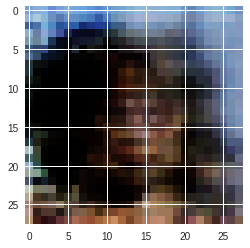

max 0.8886409
min 1.6785897e-06


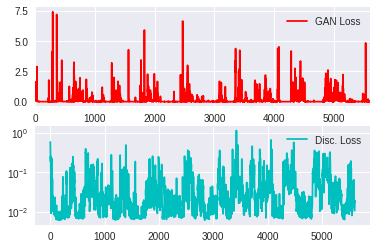

[0.0049985992518486455]
0.010851809211696187
After  5700  batches:
MINMAX 1.678153e-09 0.7256893


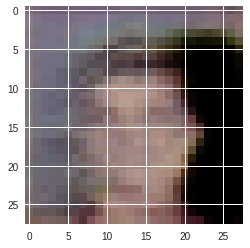

max 0.7256893
min 1.678153e-09
MINMAX 2.14773e-06 0.7450066


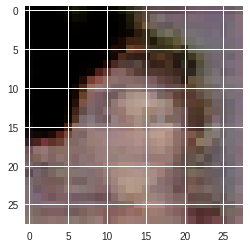

max 0.7450066
min 2.14773e-06


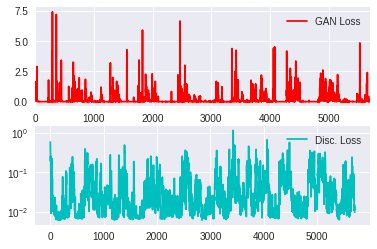

[0.009005302214063704]
0.009785184888945272
After  5800  batches:
MINMAX 1.978931e-05 0.76814365


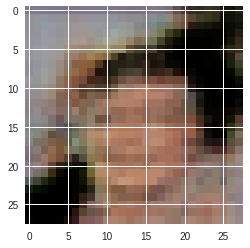

max 0.76814365
min 1.978931e-05
MINMAX 2.0813792e-14 0.79977703


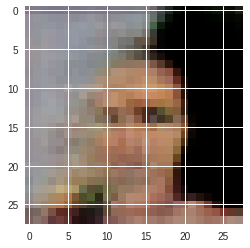

max 0.79977703
min 2.0813792e-14


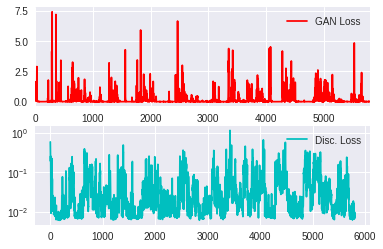

[0.009445774951018393]
0.00762937330485632
After  5900  batches:
MINMAX 2.2334348e-06 0.8213266


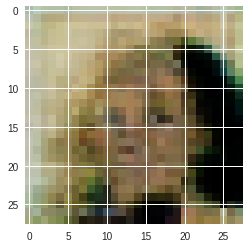

max 0.8213266
min 2.2334348e-06
MINMAX 9.768237e-07 0.81398606


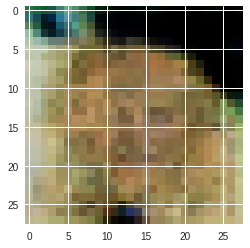

max 0.81398606
min 9.768237e-07


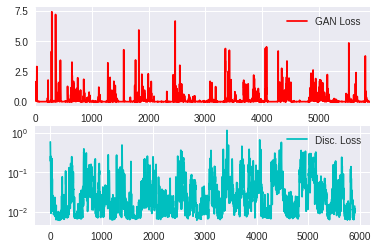

[0.0013732406951021403]
0.014016710008339336
After  6000  batches:
MINMAX 2.3434108e-09 0.9693652


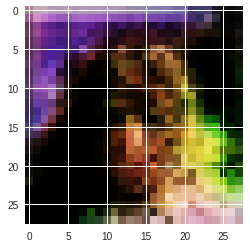

max 0.9693652
min 2.3434108e-09
MINMAX 0.00013925007 0.9166999


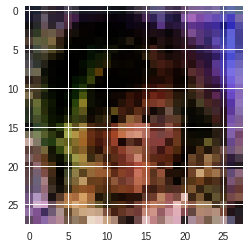

max 0.9166999
min 0.00013925007


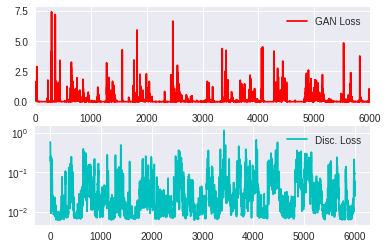

[0.018294698296813294]
0.059085518606783204
After  6100  batches:
MINMAX 3.086065e-05 0.99819595


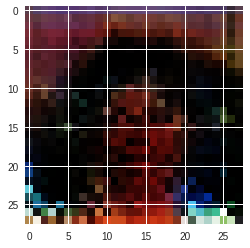

max 0.99819595
min 3.086065e-05
MINMAX 3.0250092e-05 0.95619994


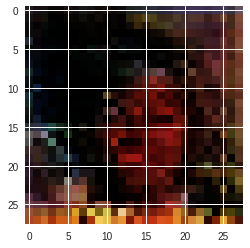

max 0.95619994
min 3.0250092e-05


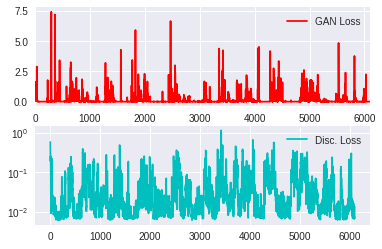

[0.004130234650801867]
0.013520044313433269
After  6200  batches:
MINMAX 1.800158e-13 0.8292173


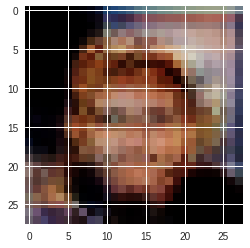

max 0.8292173
min 1.800158e-13
MINMAX 6.970663e-17 0.80719346


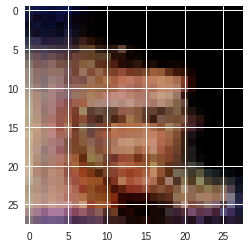

max 0.80719346
min 6.970663e-17


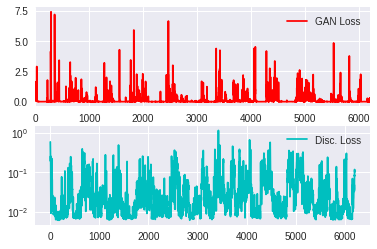

[0.021195905981585383]
0.10140153678366914
After  6300  batches:
MINMAX 0.00022993621 0.9988526


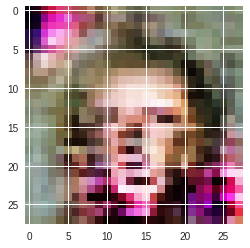

max 0.9988526
min 0.00022993621
MINMAX 0.00056606287 0.99226016


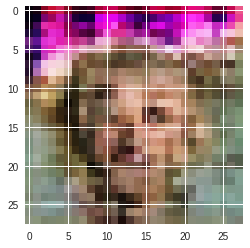

max 0.99226016
min 0.00056606287


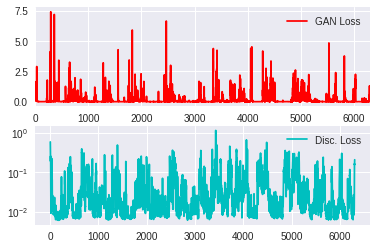

[1.1883277595043182]
0.20621727620406696
After  6400  batches:
MINMAX 2.7547182e-07 0.98231125


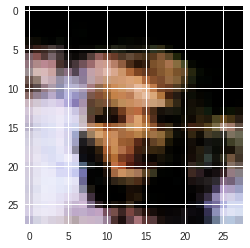

max 0.98231125
min 2.7547182e-07
MINMAX 1.7112774e-07 0.988059


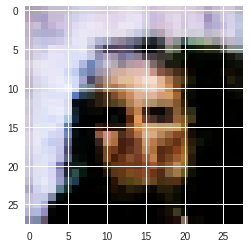

max 0.988059
min 1.7112774e-07


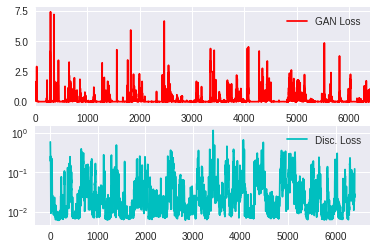

[0.5457300804555416]
0.12143718951847404
After  6500  batches:
MINMAX 0.0018437287 0.87215585


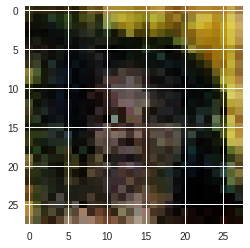

max 0.87215585
min 0.0018437287
MINMAX 0.0001093848 0.8786263


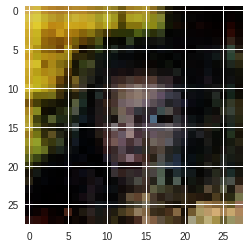

max 0.8786263
min 0.0001093848


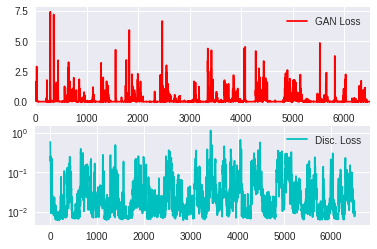

[0.001799089863197878]
0.010365997635138532
After  6600  batches:
MINMAX 0.00060752645 0.8432022


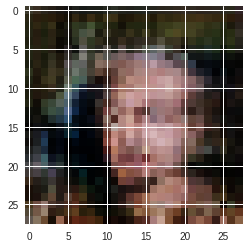

max 0.8432022
min 0.00060752645
MINMAX 0.00013091677 0.8442905


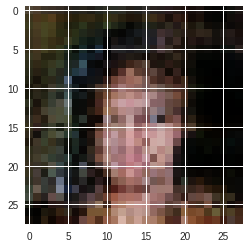

max 0.8442905
min 0.00013091677


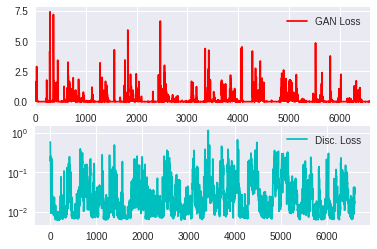

[0.0723821718711406]
0.028531374448599916
After  6700  batches:
MINMAX 4.0883115e-05 0.5330663


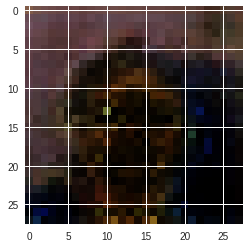

max 0.5330663
min 4.0883115e-05
MINMAX 0.00019370532 0.5284034


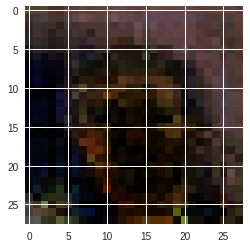

max 0.5284034
min 0.00019370532


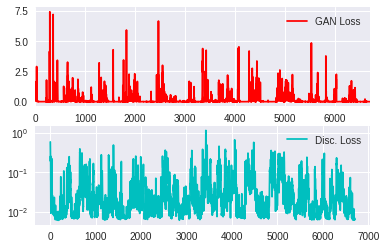

[0.00022746589002053952]
0.006627375085372478
After  6800  batches:
MINMAX 1.9223553e-07 0.5336991


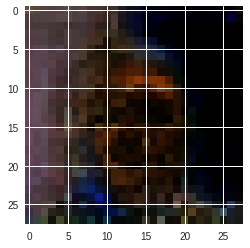

max 0.5336991
min 1.9223553e-07
MINMAX 0.0026797517 0.62790984


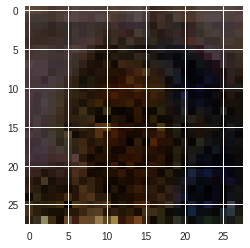

max 0.62790984
min 0.0026797517


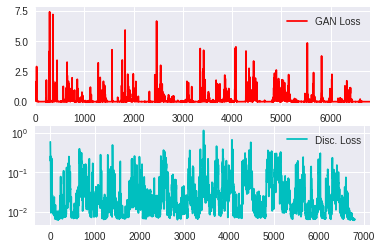

[6.378649845828477e-05]
0.006324283021967858
After  6900  batches:
MINMAX 2.5269007e-06 0.5934416


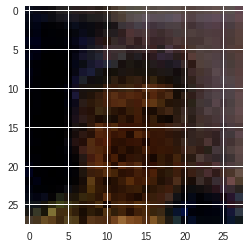

max 0.5934416
min 2.5269007e-06
MINMAX 8.57369e-05 0.52573174


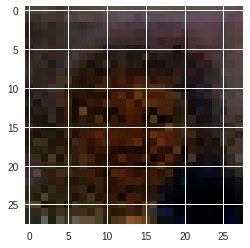

max 0.52573174
min 8.57369e-05


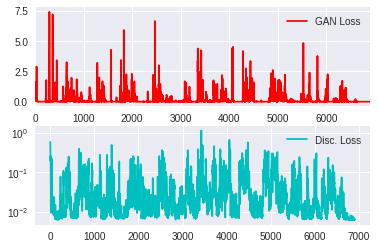

[0.00011499985430418747]
0.006483422534074634
After  7000  batches:
MINMAX 4.452771e-11 0.47773156


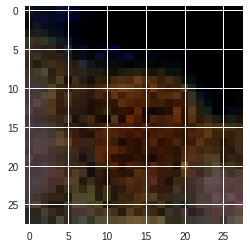

max 0.47773156
min 4.452771e-11
MINMAX 1.2063788e-07 0.42062


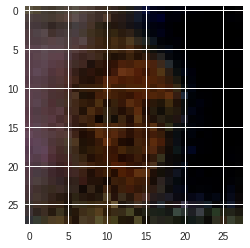

max 0.42062
min 1.2063788e-07


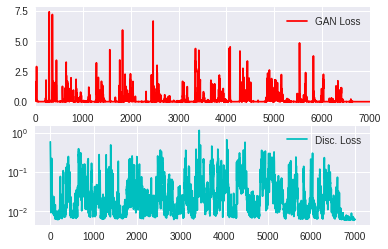

[2.4625665787425532e-05]
0.006233020802028477
After  7100  batches:
MINMAX 2.5578656e-05 0.6236006


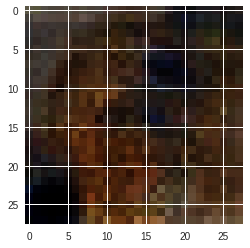

max 0.6236006
min 2.5578656e-05
MINMAX 0.0024012874 0.5548263


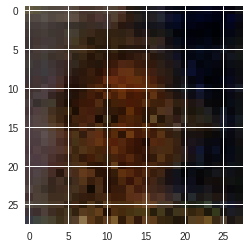

max 0.5548263
min 0.0024012874


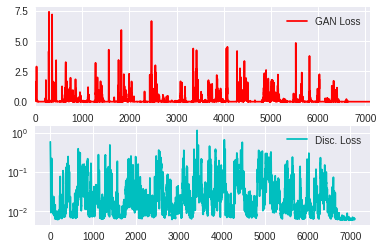

[4.2870704305641993e-05]
0.006419839667311559
After  7200  batches:
MINMAX 3.7680543e-08 0.9996517


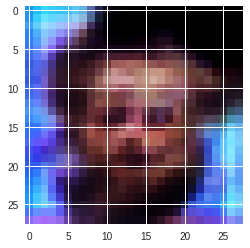

max 0.9996517
min 3.7680543e-08
MINMAX 5.2994765e-05 0.9999833


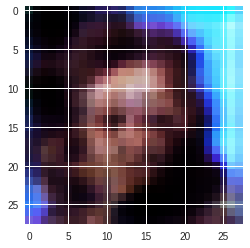

max 0.9999833
min 5.2994765e-05


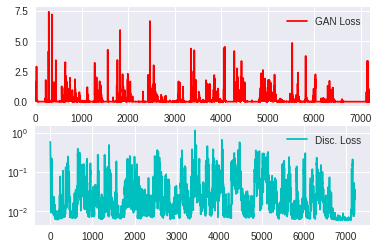

[0.005305681592290057]
0.03379510480832929
After  7300  batches:
MINMAX 0.00030065273 0.98994803


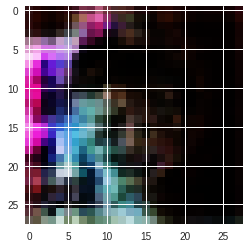

max 0.98994803
min 0.00030065273
MINMAX 0.00035472383 0.97043645


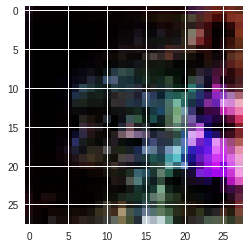

max 0.97043645
min 0.00035472383


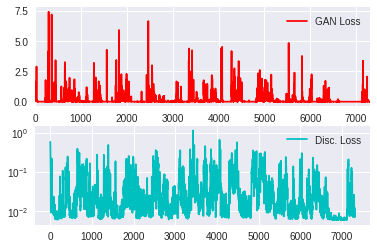

[0.006722003658069298]
0.008297728723846376
After  7400  batches:
MINMAX 0.00023460956 0.9464131


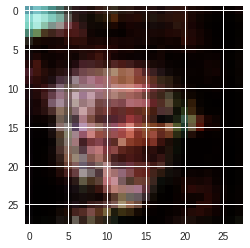

max 0.9464131
min 0.00023460956
MINMAX 9.2284805e-05 0.9275639


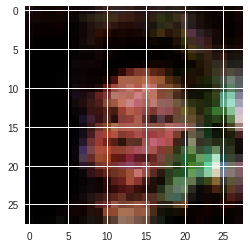

max 0.9275639
min 9.2284805e-05


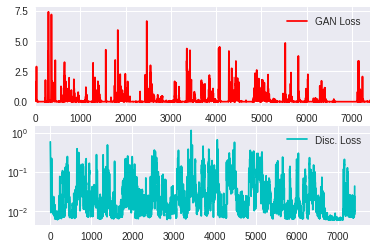

[0.10708578955382109]
0.04356710960079605
After  7500  batches:
MINMAX 0.0024060442 0.72129196


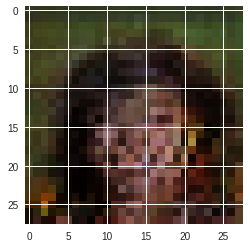

max 0.72129196
min 0.0024060442
MINMAX 0.0016343513 0.8551105


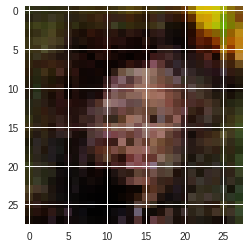

max 0.8551105
min 0.0016343513


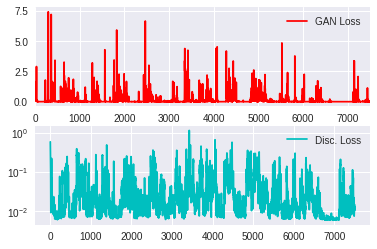

[0.004386235668789595]
0.010502781971202543
After  7600  batches:
MINMAX 0.00065021357 0.72192305


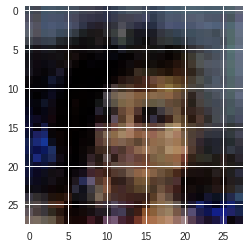

max 0.72192305
min 0.00065021357
MINMAX 0.0045378217 0.99584156


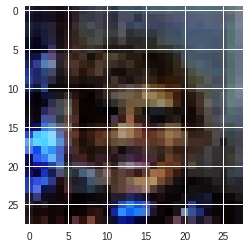

max 0.99584156
min 0.0045378217


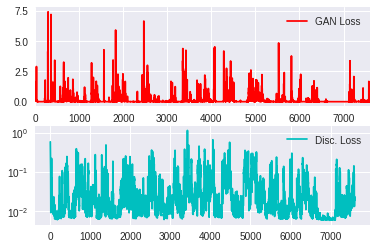

[0.0044283270835876465]
0.019050203554797918
After  7700  batches:
MINMAX 0.0066651287 0.9382729


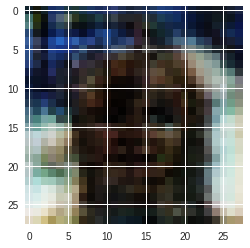

max 0.9382729
min 0.0066651287
MINMAX 0.0023778048 0.99895537


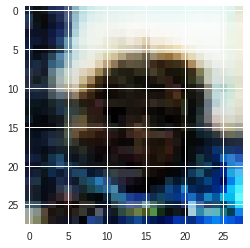

max 0.99895537
min 0.0023778048


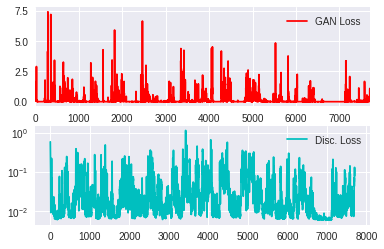

[0.055732802604325116]
0.07968810464565952
After  7800  batches:
MINMAX 0.000307795 0.9345148


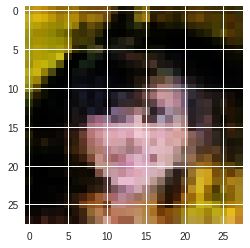

max 0.9345148
min 0.000307795
MINMAX 0.00057207944 0.9301999


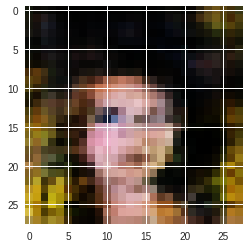

max 0.9301999
min 0.00057207944


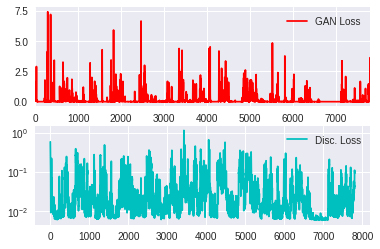

[3.615810990333557]
0.09266251729180415
After  7900  batches:
MINMAX 0.001450235 1.0


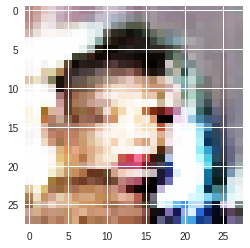

max 1.0
min 0.001450235
MINMAX 0.0018394986 0.9999994


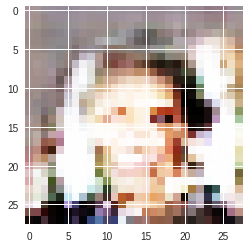

max 0.9999994
min 0.0018394986


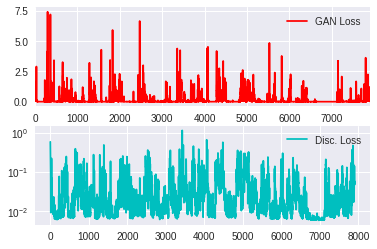

[0.9568956643342972]
0.05741129283948491
After  8000  batches:
MINMAX 1.801134e-05 0.98973083


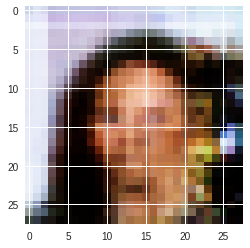

max 0.98973083
min 1.801134e-05
MINMAX 4.789756e-06 0.9999721


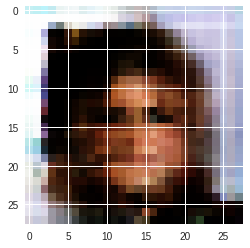

max 0.9999721
min 4.789756e-06


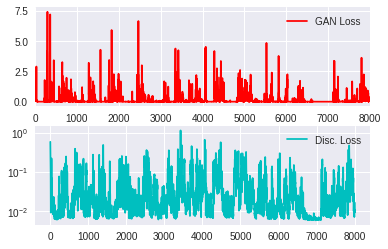

[0.37716805562376976]
0.010745367772566775
After  8100  batches:
MINMAX 0.00044279807 0.9998004


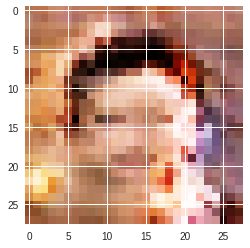

max 0.9998004
min 0.00044279807
MINMAX 0.0013028745 0.9999918


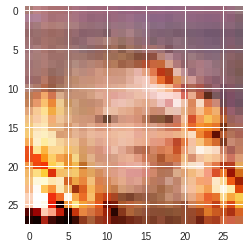

max 0.9999918
min 0.0013028745


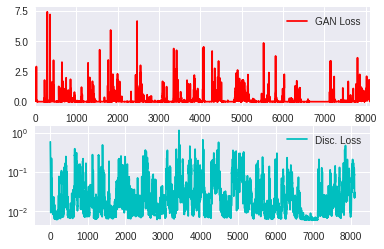

[0.10737744625657797]
0.022528958642700065
After  8200  batches:
MINMAX 6.264379e-07 0.99441296


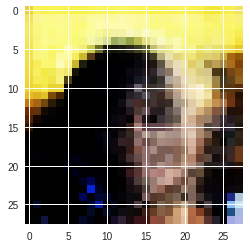

max 0.99441296
min 6.264379e-07
MINMAX 3.242752e-05 0.9988506


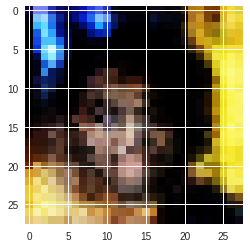

max 0.9988506
min 3.242752e-05


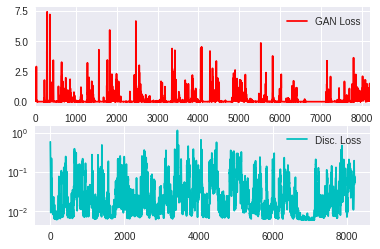

[0.18639964098110795]
0.057910748097735144
After  8300  batches:
MINMAX 4.049424e-05 0.93220985


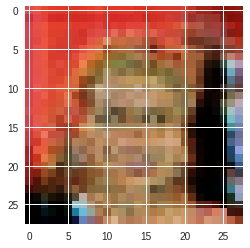

max 0.93220985
min 4.049424e-05
MINMAX 8.189484e-13 0.95976925


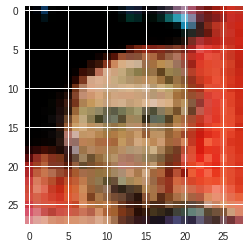

max 0.95976925
min 8.189484e-13


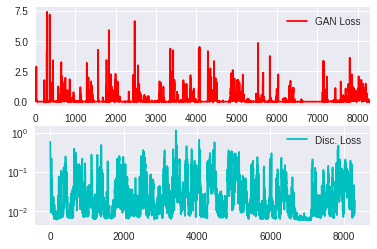

[0.03385148546658456]
0.009286339724591622
After  8400  batches:
MINMAX 0.0002448766 0.8165957


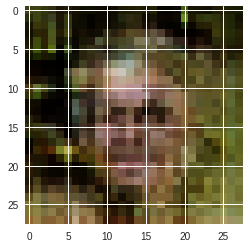

max 0.8165957
min 0.0002448766
MINMAX 1.4061494e-06 0.7226232


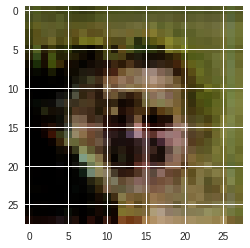

max 0.7226232
min 1.4061494e-06


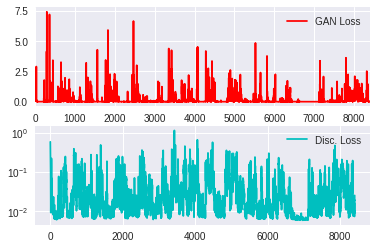

[0.01959878340130672]
0.025325592432636768
After  8500  batches:
MINMAX 2.366894e-05 0.85758954


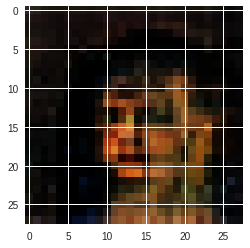

max 0.85758954
min 2.366894e-05
MINMAX 0.00060303655 0.85028374


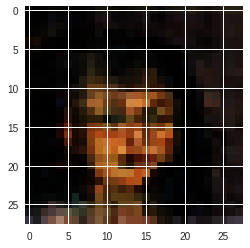

max 0.85028374
min 0.00060303655


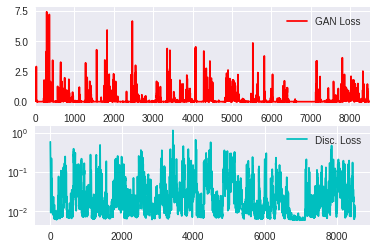

[0.0022082219293224625]
0.012295035975209126
After  8600  batches:
MINMAX 0.00014290119 0.71916866


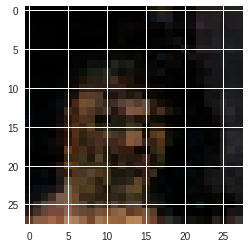

max 0.71916866
min 0.00014290119
MINMAX 0.0014424475 0.66470844


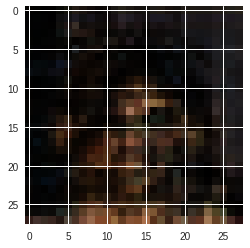

max 0.66470844
min 0.0014424475


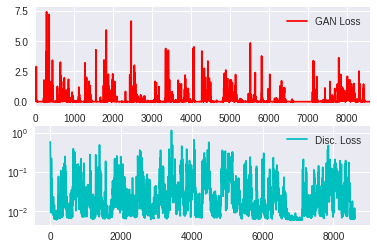

[0.0001657875327509828]
0.006632527491698663
After  8700  batches:
MINMAX 0.0001494507 0.9157391


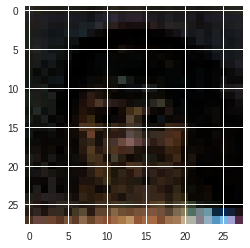

max 0.9157391
min 0.0001494507
MINMAX 7.194497e-06 0.9069891


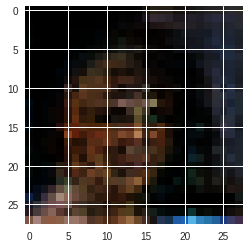

max 0.9069891
min 7.194497e-06


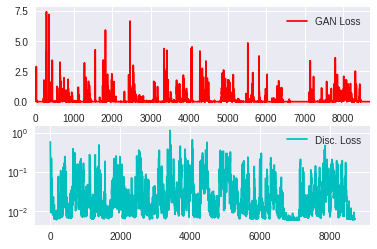

[0.0002279086893395288]
0.0065532784210518
After  8800  batches:
MINMAX 0.00016778674 0.9879304


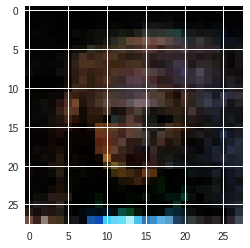

max 0.9879304
min 0.00016778674
MINMAX 1.8102894e-06 0.5103034


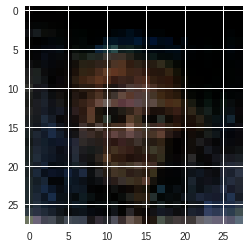

max 0.5103034
min 1.8102894e-06


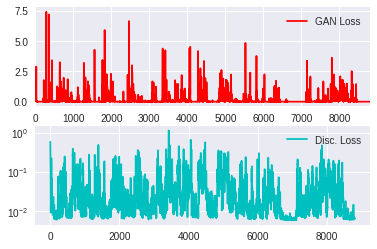

[0.00016642595664961846]
0.006556429880826424
After  8900  batches:
MINMAX 6.7367924e-05 0.63816136


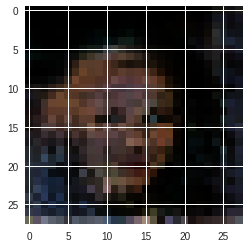

max 0.63816136
min 6.7367924e-05
MINMAX 0.00015950426 0.6392004


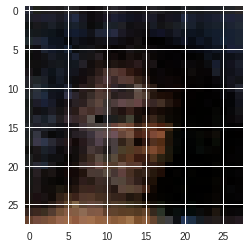

max 0.6392004
min 0.00015950426


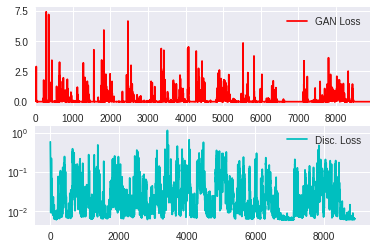

[0.00010874842519115191]
0.006528128171339631
After  9000  batches:
MINMAX 4.657285e-12 0.967187


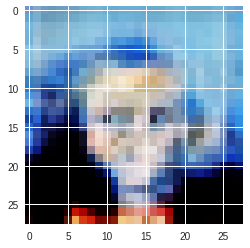

max 0.967187
min 4.657285e-12
MINMAX 2.458172e-11 0.9611415


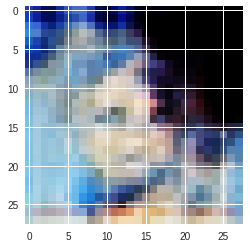

max 0.9611415
min 2.458172e-11


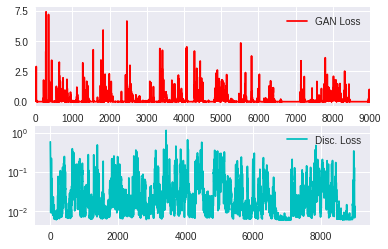

[0.025805682525970042]
0.01252113119699061
After  9100  batches:
MINMAX 1.6162374e-11 0.9643253


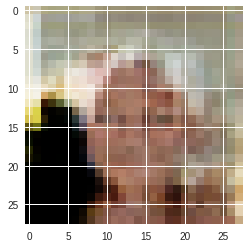

max 0.9643253
min 1.6162374e-11
MINMAX 7.3751346e-07 0.9741518


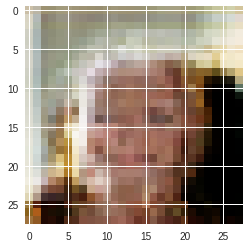

max 0.9741518
min 7.3751346e-07


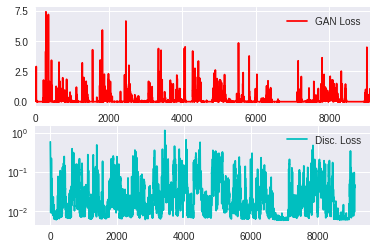

[1.0623034536838531]
0.040062129439320415
After  9200  batches:
MINMAX 0.0010171647 0.9269853


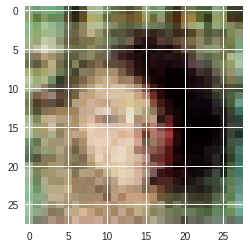

max 0.9269853
min 0.0010171647
MINMAX 2.7774287e-05 0.9076218


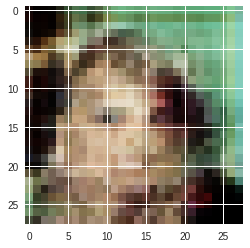

max 0.9076218
min 2.7774287e-05


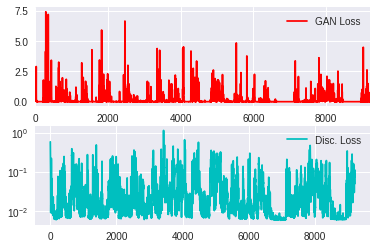

[0.17373590636998415]
0.07552169214856501
After  9300  batches:
MINMAX 0.00050099543 0.9679415


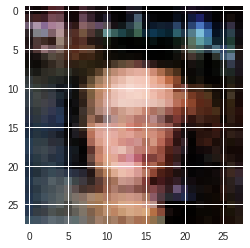

max 0.9679415
min 0.00050099543
MINMAX 0.00037794097 0.9968995


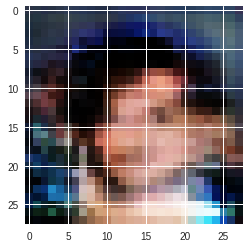

max 0.9968995
min 0.00037794097


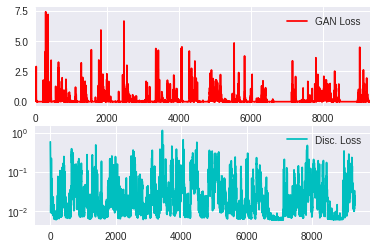

[0.00832598257693462]
0.017316660785581917
After  9400  batches:
MINMAX 1.1692931e-10 0.9993886


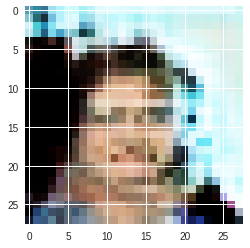

max 0.9993886
min 1.1692931e-10
MINMAX 1.248023e-05 0.99825484


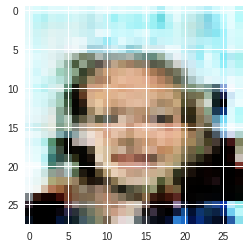

max 0.99825484
min 1.248023e-05


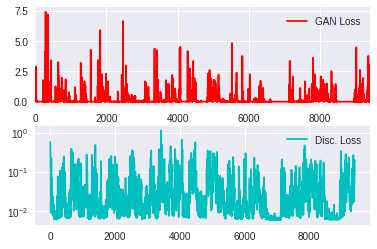

[0.14259981270879507]
0.19810777405897775
After  9500  batches:
MINMAX 3.150059e-05 0.98787874


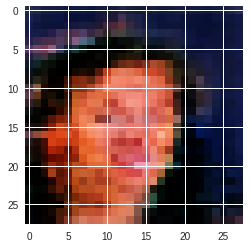

max 0.98787874
min 3.150059e-05
MINMAX 0.00014247218 0.9615446


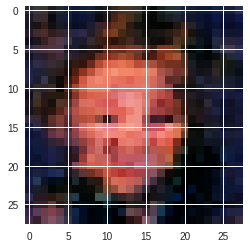

max 0.9615446
min 0.00014247218


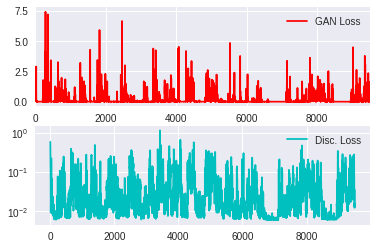

[0.029966075555421412]
0.03504272364079952
After  9600  batches:
MINMAX 0.0040114955 0.9654511


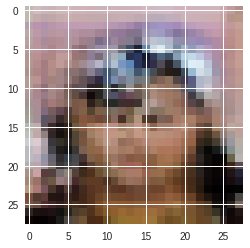

max 0.9654511
min 0.0040114955
MINMAX 4.110834e-05 0.9960879


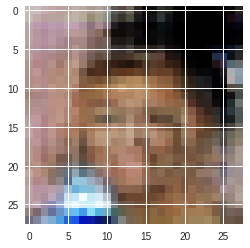

max 0.9960879
min 4.110834e-05


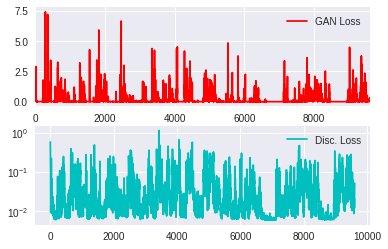

[0.0699661998078227]
0.05175357509870082
After  9700  batches:
MINMAX 0.0002856146 0.98515576


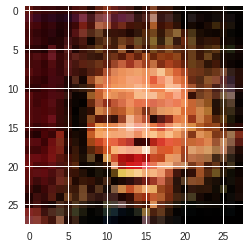

max 0.98515576
min 0.0002856146
MINMAX 0.0006776984 0.98161536


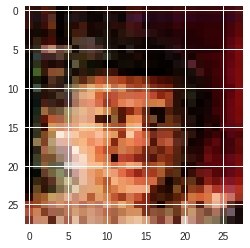

max 0.98161536
min 0.0006776984


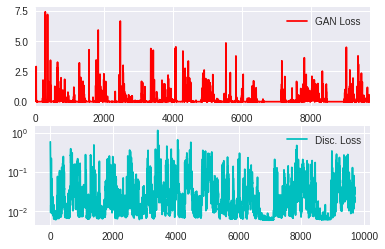

[0.009904262551572174]
0.022679758762630325
After  9800  batches:
MINMAX 5.7946486e-06 0.94423646


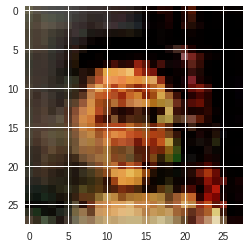

max 0.94423646
min 5.7946486e-06
MINMAX 2.8431025e-06 0.9783357


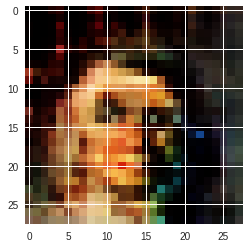

max 0.9783357
min 2.8431025e-06


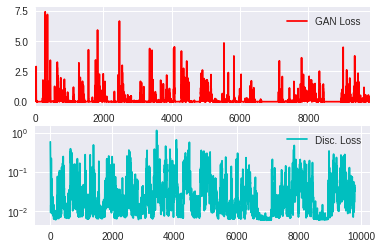

[0.04860895639285445]
0.039145123679190874
After  9900  batches:
MINMAX 1.1530059e-22 0.9887207


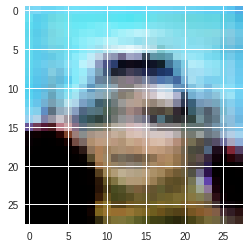

max 0.9887207
min 1.1530059e-22
MINMAX 3.6411348e-07 0.97352725


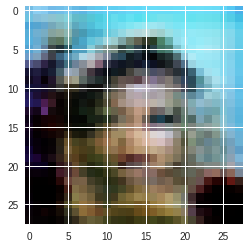

max 0.97352725
min 3.6411348e-07


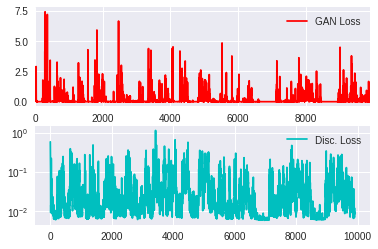

[0.011340776283759624]
0.009341832036928585
After  10000  batches:
MINMAX 1.8367802e-05 0.9998311


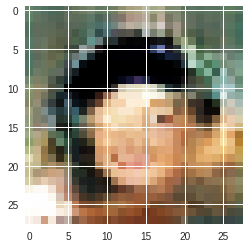

max 0.9998311
min 1.8367802e-05
MINMAX 0.00037413393 0.9839392


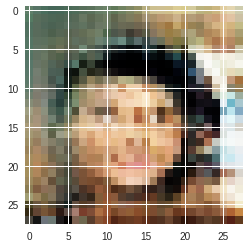

max 0.9839392
min 0.00037413393


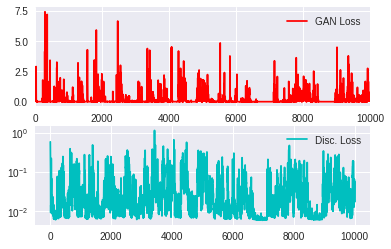

[0.20025416277348995]
0.05738744733389467


In [20]:
train(10000)



Plot several examples of generated images:

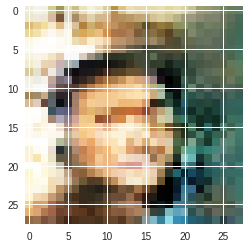

max 0.9996891
min 0.0012853544


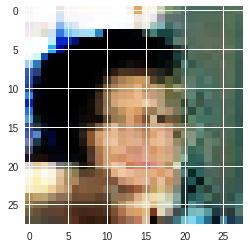

max 0.9996761
min 4.6309246e-08


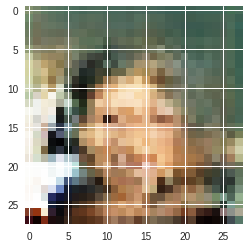

max 0.99925643
min 0.0028592285


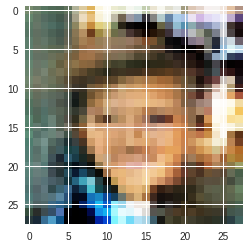

max 0.99803597
min 1.8478418e-05


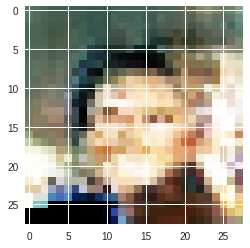

max 0.99998665
min 9.137168e-08


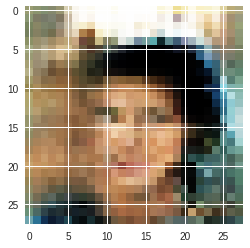

max 0.9999126
min 0.00027777476


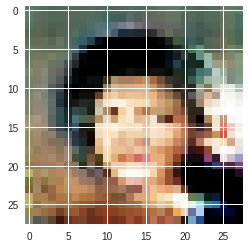

max 0.9989126
min 2.7814835e-07


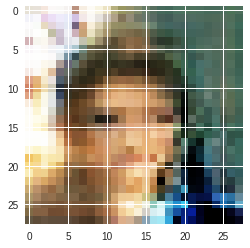

max 0.99980205
min 4.1545834e-05


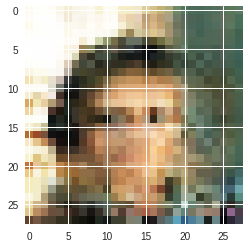

max 0.9999747
min 0.025749927


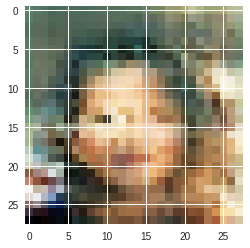

max 0.9831376
min 0.00065351377


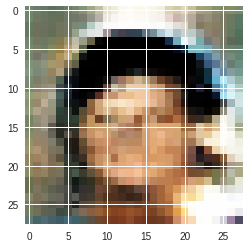

max 0.99998724
min 1.2887855e-07


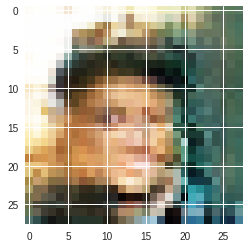

max 0.9999405
min 0.017082715


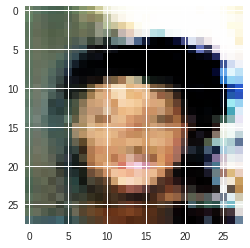

max 0.99999774
min 1.2160532e-06


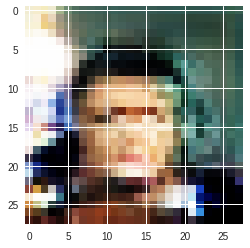

max 0.9999894
min 2.1259357e-10


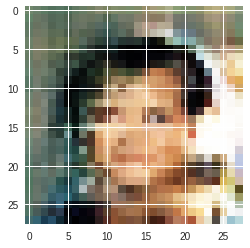

max 0.9999815
min 0.003609937


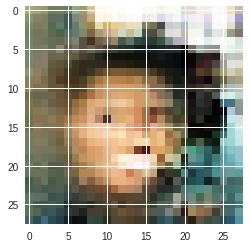

max 0.99912983
min 0.01453273


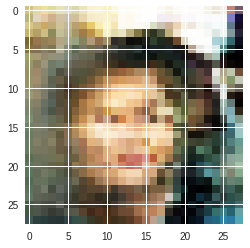

max 0.9993895
min 0.0050322516


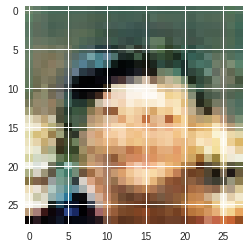

max 0.99541867
min 0.003916511


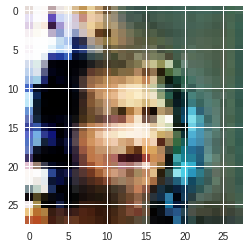

max 0.9995357
min 2.6914981e-06


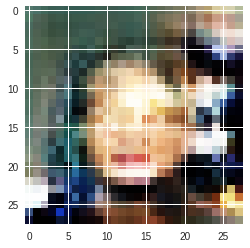

max 0.9993807
min 9.69606e-05


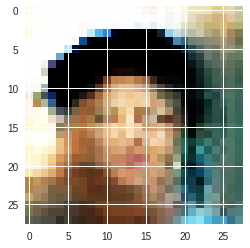

max 0.9999994
min 3.0649947e-09


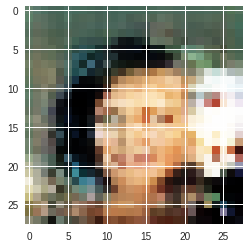

max 0.9999956
min 8.352224e-05


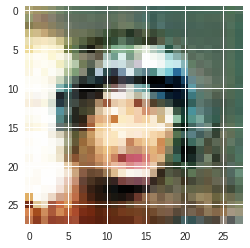

max 0.99993086
min 0.002297786


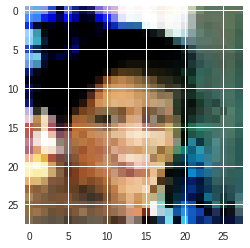

max 0.9990331
min 4.1372462e-07


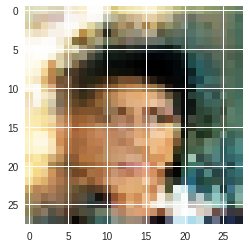

max 0.99924785
min 0.0017854788


In [24]:
plot_generated_images(25)



## Summary

A generative adversarial network was successfully trained to draw faces using a convolutional neural networks as the descriminator and generator models. Hyperparameter tuning and network design would likely lead to improved training times and better images.
  